## Setup the Env


In [1]:
import os
import sys

import sagemaker
from sagemaker import get_execution_role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Define IAM role
role = get_execution_role()
role

# Establish S3 bucket connection
import boto3

s3 = boto3.client("s3")
bucket = "capstone-bucket-4-friends"

# Take a look at current dir
print(os.getcwd())

from file_utilities import s3_download

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
/home/sagemaker-user/capstone-2024-summer/src/shuo


## Import Package

In [2]:
!pip install seaborn
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import time
import logging

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

In [3]:
# pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113


In [4]:
torch.cuda.is_available()


True

In [5]:
import torch
import torch.nn as nn

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# Example model
model = nn.Linear(10, 2)

# Move model to the device (GPU if available)
model.to(device)

# Example data
x = torch.randn(1, 10).to(device)
output = model(x)
print(output)


CUDA is available. Using GPU.
tensor([[-0.8958, -0.0072]], device='cuda:0', grad_fn=<AddmmBackward0>)


## Load Data

In [6]:
# reload_path = s3_download("CRSP/crsp_2018-2023_clean_3.parquet")
# reload_path

In [7]:
os.getcwd()

'/home/sagemaker-user/capstone-2024-summer/src/shuo'

In [8]:
!pwd

/home/sagemaker-user/capstone-2024-summer/src/shuo


In [9]:
df = pd.read_parquet("../../data/crsp_2018-2023_clean_3.parquet")

In [10]:
df

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,return_14,log_return_14,abs_log_return_14,price_28,return_28,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,4.231880,0.131071,0.131071,48.15,0.334682,0.011619,0.011619,0.136136,0.109282,0.276310
9264,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,2.890159,0.107382,0.107382,48.49,0.157137,0.006475,0.006475,0.091648,0.081082,0.268724
9265,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,2.436310,0.097613,0.097613,49.45,0.263850,0.009651,0.009651,0.089939,0.079524,0.273385
9266,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,3.586591,0.120486,0.120486,50.64,0.483153,0.015437,0.015437,0.105015,0.107098,0.281463
9267,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,1.875391,0.083731,0.083731,50.71,0.366701,0.012476,0.012476,0.105560,0.139328,0.280139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656951,2023-12-22,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656952,2023-12-26,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656953,2023-12-27,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656954,2023-12-28,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
df.dtypes

date                              datetime64[ns]
permno_id                                 object
ncusip_id                                 object
cusip_id                                  object
ticker                                    object
share_code                                object
share_code_type                           object
share_code_detail                         object
exchange_code                             object
company_name                              object
primary_exchange                          object
trading_status                            object
security_status                           object
naics                                     object
naics_sector                              object
naics_sector_name                         object
naics_secondary                           object
ask_or_high_price                        float64
ask_price                                float64
bid_or_low_price                         float64
bid_price           

## Feature Engineering

### Feature Selection

In [12]:
data = df[
    [
        "date",
        "permno_id",
        # "naics",
        "log_return",
        "abs_log_return",
        "sector_weighted_avg_log_return",
        "sector_simple_avg_log_return",
        "weighted_avg_log_return",
        "simple_avg_log_return",
        "log_return_7",
        "abs_log_return_7",
        "log_return_14",
        "abs_log_return_14",
        "log_return_28",
        "abs_log_return_28",
        "volatility_7",
        "volatility_14",
        "volatility_28",
    ]
]
data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,-0.013843,0.013843,0.000000,0.000000,0.000000,0.000000,0.309424,0.309424,0.131071,0.131071,0.011619,0.011619,0.136136,0.109282,0.276310
9264,2018-01-03,10104,0.022897,0.022897,0.006404,0.004872,0.005904,0.007983,0.234088,0.234088,0.107382,0.107382,0.006475,0.006475,0.091648,0.081082,0.268724
9265,2018-01-04,10104,0.009803,0.009803,0.004048,0.000960,0.004021,0.000852,0.183199,0.183199,0.097613,0.097613,0.009651,0.009651,0.089939,0.079524,0.273385
9266,2018-01-05,10104,0.006001,0.006001,0.009581,0.006722,0.006193,0.002919,0.230474,0.230474,0.120486,0.120486,0.015437,0.015437,0.105015,0.107098,0.281463
9267,2018-01-08,10104,0.010467,0.010467,0.002142,0.005354,0.001829,0.005828,0.161223,0.161223,0.083731,0.083731,0.012476,0.012476,0.105560,0.139328,0.280139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656951,2023-12-22,93436,-0.007731,0.007731,0.000259,0.007069,0.002502,0.004469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656952,2023-12-26,93436,0.015988,0.015988,0.007335,0.009616,0.005189,0.003873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656953,2023-12-27,93436,0.018647,0.018647,0.002344,0.001393,0.001653,0.001163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656954,2023-12-28,93436,-0.032104,0.032104,-0.001451,-0.000214,-0.000266,0.002184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
# data["naics_sector_digits"] = data["naics"].astype(str).str[:2]
# data

### Add positional_encoding

In [14]:
# data["positional_encoding"] = data.groupby("permno_id").cumcount() + 1
# data

### Check inf and missing values

In [15]:
def check_data(df):
    if df.isnull().values.any():
        print("Data contains NaNs")
    if np.isinf(pd.to_numeric(df.stack(), errors="coerce")).any():
        print("Data contains Infinities")


check_data(data)

In [16]:
data[-30:]

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
7656926,2023-11-16,93436,-0.038835,0.038835,-0.000869,-0.004937,-0.001334,0.004114,0.324775,0.324775,0.050085,0.050085,0.026224,0.026224,0.355413,0.288883,0.330446
7656927,2023-11-17,93436,0.003035,0.003035,0.002385,0.003949,0.003156,-0.000656,0.235617,0.235617,0.052651,0.052651,0.019067,0.019067,0.371970,0.289036,0.336745
7656928,2023-11-20,93436,0.005533,0.005533,0.009430,0.007483,0.007163,0.006781,0.101719,0.101719,0.022650,0.022650,0.000000,0.000000,0.396123,0.300512,0.000000
7656929,2023-11-21,93436,0.023491,0.023491,-0.002472,-0.003581,-0.003160,-0.001215,-0.049519,0.049519,-0.022278,0.022278,0.000000,0.000000,0.369358,0.286615,0.000000
7656930,2023-11-22,93436,-0.029408,0.029408,-0.001036,0.004794,0.004151,0.004135,0.030445,0.030445,0.027974,0.027974,0.000000,0.000000,0.329192,0.258743,0.000000
7656931,2023-11-24,93436,0.005280,0.005280,-0.000404,0.006189,0.000437,0.001657,0.073508,0.073508,0.085981,0.085981,0.000000,0.000000,0.337080,0.325520,0.000000
7656932,2023-11-27,93436,0.002672,0.002672,-0.001712,-0.003564,-0.002027,-0.003296,0.073767,0.073767,0.095855,0.095855,0.000000,0.000000,0.337084,0.326089,0.000000
7656933,2023-11-28,93436,0.044083,0.044083,-0.000177,-0.008462,0.000747,-0.002023,-0.082184,0.082184,0.028019,0.028019,0.000000,0.000000,0.198041,0.275052,0.000000
7656934,2023-11-29,93436,-0.010512,0.010512,0.002796,0.005689,0.000772,-0.001893,-0.006302,0.006302,0.069404,0.069404,0.000000,0.000000,0.193030,0.279782,0.000000
7656935,2023-11-30,93436,-0.016770,0.016770,-0.000674,0.003475,0.003368,0.004055,-0.007258,0.007258,0.037967,0.037967,0.000000,0.000000,0.193708,0.326211,0.000000


In [17]:
data.describe()

,date,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
count,809883,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000
mean,2021-01-02 19:26:16.187671808,0.000347,0.015239,0.000340,0.000143,0.000335,0.000226,0.062016,0.221782,0.011755,0.075367,0.003473,0.026526,0.299785,0.309311,0.315029
min,2018-01-02 00:00:00,-0.773592,0.000000,-1.949859,-0.510336,-0.129686,-0.095060,-0.999627,0.000000,-0.918449,0.000000,-0.505787,0.000000,0.000000,0.000000,0.000000
25%,2019-07-10 00:00:00,-0.009627,0.004608,-0.006371,-0.006763,-0.005049,-0.005496,-0.119866,0.067578,-0.043232,0.024668,-0.014979,0.008843,0.167155,0.186708,0.200940
50%,2021-01-05 00:00:00,0.000817,0.010260,0.000887,0.000677,0.000743,0.000637,0.024535,0.150276,0.010485,0.054429,0.004058,0.019569,0.243410,0.259283,0.269265
75%,2022-07-01 00:00:00,0.010825,0.019626,0.007900,0.008082,0.007133,0.006488,0.181726,0.279142,0.063910,0.100071,0.023282,0.035404,0.359321,0.363738,0.365940
max,2023-12-29 00:00:00,0.629788,0.773592,4.629079,1.409433,0.090241,0.100972,122.448772,122.448772,4.453196,4.453196,0.758288,0.758288,5.258937,4.398254,3.282485
std,NaN,0.023655,0.018095,0.018470,0.015654,0.013260,0.012536,0.483496,0.434081,0.108734,0.079254,0.037834,0.027200,0.228246,0.212317,0.200876


In [18]:
# # Check if there are any infinite values in the entire DataFrame
# infinite_values = data.isin([np.inf, -np.inf]).values.any()
# print(f"Data contains Infinities: {infinite_values}")

# # Check for specific columns
# column_with_inf = data.isin([np.inf, -np.inf]).any()
# print("Columns with Infinities:")
# print(column_with_inf[column_with_inf].index.tolist())

In [19]:
# data_inf_rows = data[(data == np.inf) | (data == -np.inf)].any(axis=1)
# data[data_inf_rows]

In [20]:
# Define a function to remove the last 28 rows for each permno_id
def remove_last_n_rows(df, n):
    # Group by 'permno_id'
    groups = df.groupby("permno_id")
    # Remove last n rows for each group
    df_cleaned = groups.apply(lambda x: x.iloc[:-n] if len(x) > n else x)
    # Remove the extra groupby level
    df_cleaned.reset_index(drop=True, inplace=True)
    return df_cleaned

In [21]:
# Remove the last 28 rows for each permno_id
cleaned_data = remove_last_n_rows(data, 28)
cleaned_data[-30:]

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
794341,2023-10-09,93436,-0.003306,0.003306,0.004974,0.006552,0.005551,-0.000367,-0.293906,0.293906,-0.251437,0.251437,-0.033449,0.033449,0.371351,0.504321,0.566852
794342,2023-10-10,93436,0.015097,0.015097,0.005459,0.009881,0.006468,0.008715,-0.604529,0.604529,-0.310775,0.310775,-0.037190,0.037190,0.600659,0.500945,0.564252
794343,2023-10-11,93436,-0.002393,0.002393,0.004413,0.000132,0.003790,0.001008,-0.670007,0.670007,-0.292939,0.292939,-0.034734,0.034734,0.579893,0.521671,0.564991
794344,2023-10-12,93436,-0.015790,0.015790,-0.006896,-0.016643,-0.008780,-0.010085,-0.641309,0.641309,-0.256098,0.256098,-0.022469,0.022469,0.605129,0.552761,0.569565
794345,2023-10-13,93436,-0.030395,0.030395,-0.141350,-0.013752,-0.005451,-0.003587,-0.533462,0.533462,-0.163762,0.163762,-0.022159,0.022159,0.672323,0.636680,0.569121
794346,2023-10-16,93436,0.011088,0.011088,0.008951,0.013014,0.009906,0.011120,-0.600587,0.600587,-0.168558,0.168558,-0.023983,0.023983,0.634819,0.634094,0.568094
794347,2023-10-17,93436,0.003656,0.003656,-0.005996,0.002844,0.001109,0.002598,-0.667258,0.667258,-0.175794,0.175794,-0.024291,0.024291,0.601200,0.631855,0.567999
794348,2023-10-18,93436,-0.048932,0.048932,-0.019949,-0.024705,-0.015139,-0.017764,-0.555317,0.555317,-0.107271,0.107271,0.005321,0.005321,0.623632,0.613775,0.565927
794349,2023-10-19,93436,-0.097616,0.097616,-0.013942,-0.014399,-0.009451,-0.007062,-0.429405,0.429405,0.011698,0.011698,0.033865,0.033865,0.409488,0.450199,0.478414
794350,2023-10-20,93436,-0.037589,0.037589,-0.013804,-0.011470,-0.012873,-0.009276,-0.242604,0.242604,-0.012174,0.012174,0.040807,0.040807,0.418413,0.486228,0.465549


In [26]:
cleaned_data.isnull().sum()

date                              0
permno_id                         0
log_return                        0
abs_log_return                    0
sector_weighted_avg_log_return    0
sector_simple_avg_log_return      0
weighted_avg_log_return           0
simple_avg_log_return             0
log_return_7                      0
abs_log_return_7                  0
log_return_14                     0
abs_log_return_14                 0
log_return_28                     0
abs_log_return_28                 0
volatility_7                      0
volatility_14                     0
volatility_28                     0
dtype: int64

In [23]:
# train_data = data[(data["date"] <= "2022-12-31") & (data["date"] >= "2022-01-02")]
# train_data = data[data["date"] <= "2022-12-31"]
# validation_data = data[data["date"] > "2022-12-31"]
# train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
# validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

In [24]:
# train_data

In [25]:
# validation_data

## Model
1. Need to have 1 modified transformer encoder layer without residual connections + (n-1) standard layers
2. Need to connect the output of the first transformer block to the embedding layer of the fi- nal encoder block

### Case 0: Model (128 days, 7 features and 11 targets)
Features:  
'log_return'  
'postional encoding'  
"sector_weighted_avg_log_return"  
"sector_simple_avg_log_return"  
"weighted_avg_log_return"  
"simple_avg_log_return"  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Labels:
"log_return"  
"abs_log_return"  
"log_return_7"  
"abs_log_return_7"  
"log_return_14"  
"abs_log_return_14"  
"log_return_28"  
"abs_log_return_28"  
"volatility_7"  
"volatility_14"  
"volatility_28"

#### Create Dataset

In [28]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data["positional_encoding"] = self.data.groupby("permno_id").cumcount()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values
                    # print(X)
                    # permno_id_one_hot_repeated = np.tile(permno_id_one_hot[i], (self.window_size, 1))
                    # print(permno_id_one_hot_repeated.shape)
                    # positional_encoding = np.arange(self.window_size).reshape(-1, 1)
                    # print(positional_encoding.shape)
                    X = np.concatenate(
                        [X, permno_id_one_hot[i : i + self.window_size]], axis=1
                    )  # Concatenate one-hot encoded permno_id
                    X = np.concatenate(
                        [X, group["positional_encoding"].iloc[i : i + self.window_size].values.reshape(-1, 1)], axis=1
                    )
                    # X = np.concatenate([X, permno_id_one_hot_repeated, positional_encoding], axis=1)
                    # print(X.shape)
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }

In [29]:
# Function to filter the first n stocks
def filter_first_n_stocks(data, n):
    first_n_permno_ids = data["permno_id"].unique()[:n]
    return data[data["permno_id"].isin(first_n_permno_ids)]

#### 1-Train 20 Stocks

In [29]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Filter the first n stocks
n_stocks = 20  # Adjust n as needed
cleaned_data_n_stocks = filter_first_n_stocks(cleaned_data, n_stocks)

# Split data
train_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] <= "2023-09-30"]
validation_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 24452
Validation Dataset Length: 595
{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  2.0000e+00],
        ...,
        [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2500e+02],
        [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2600e+02],
        [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.2700e+02]]), 'target': tensor([0.0129, 0.0129, 0.3973, 0.3973, 0.0864, 0.0864, 0.0140, 0.0140, 0.0811,
        0.1040, 0.1251]), 'permno_id': '10104'}
CPU times: user 17.5 s, sys: 5.8 s, total: 23.3 s
Wall time: 23.2 s


#### Build and Train Model

In [30]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

Starting Training...
Epoch 1/5 took 21.70 seconds
Epoch 1/5, Training Loss: 0.09780969822328854, Validation Loss: 0.0681546793172234
Epoch 2/5 took 21.59 seconds
Epoch 2/5, Training Loss: 0.08445373486264858, Validation Loss: 0.06610344409158356
Epoch 3/5 took 21.73 seconds
Epoch 3/5, Training Loss: 0.08077439733239171, Validation Loss: 0.06661216797013032
Epoch 4/5 took 21.48 seconds
Epoch 4/5, Training Loss: 0.07860314932718776, Validation Loss: 0.06651004384222783
Epoch 5/5 took 21.49 seconds
Epoch 5/5, Training Loss: 0.07696837289806674, Validation Loss: 0.06706552227076731
Early stopping triggered.
Training Complete


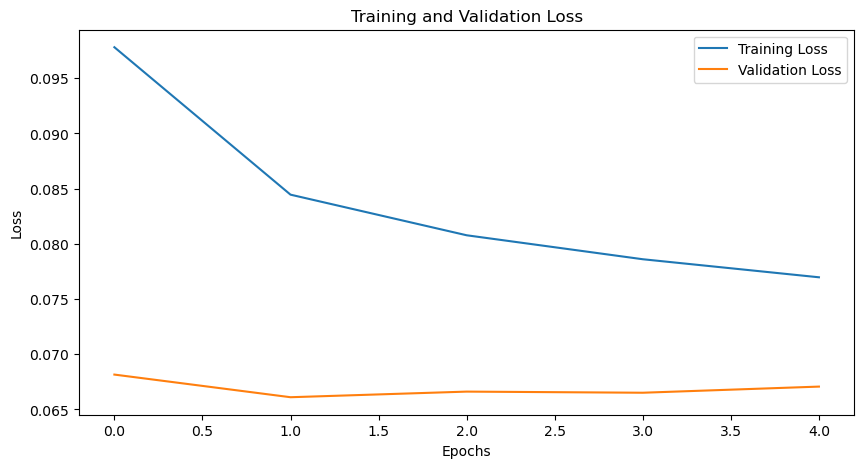

CPU times: user 13min 20s, sys: 6.44 s, total: 13min 27s
Wall time: 1min 48s


In [31]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [32]:
%%time
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

CPU times: user 2min 23s, sys: 234 ms, total: 2min 23s
Wall time: 7.67 s


In [33]:
%%time
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

CPU times: user 28.3 ms, sys: 0 ns, total: 28.3 ms
Wall time: 27.4 ms


In [34]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-1.43368006e-01,  1.06011689e-01, -1.48143575e-01,  3.88575733e-01,
          5.99555552e-01, -5.75772412e-02, -1.06031962e-01,  1.79427653e-03,
         -2.15266064e-01,  1.39724791e+00,  4.59417999e-01,  1.20730512e-01,
         -3.36007237e-01, -4.44641799e-01, -1.49419248e+00,  2.12527916e-01,
          5.78680098e-01, -1.88101387e+00,  1.30238771e-01, -1.61442876e-01,
         -5.49131989e-01,  3.43328655e-01,  1.26686752e-01, -7.00123236e-02,
          1.37534678e+00,  6.97882893e-03, -2.26395279e-01,  2.33613953e-01,
         -2.55678773e+00, -3.76272619e-01,  8.49202514e-01,  5.52053191e-02,
         -1.59065738e-01, -1.23829114e+00, -8.36773276e-01,  3.66478354e-01,
          1.28376389e+00, -1.49030530e+00, -6.21318966e-02,  1.25528145e+00,
         -2.72501051e-01, -1.67729628e+00,  5.41175187e-01,  6.10998049e-02,
         -7.10754022e-02,  3.11420802e-02, -1.30190790e+00,  1.31102860e-01,
         -4.70663384e-02, -1.09268941e-01, -3.16818394e-02,  6.36

#### Cosine Similarity Matrix

In [35]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

CPU times: user 1.56 ms, sys: 44 μs, total: 1.6 ms
Wall time: 1.23 ms


array([[1.        , 0.99999994, 0.99999994, 0.99999994, 0.99999994,
        0.9999996 , 0.9999644 , 0.99999976, 1.0000001 , 0.9999997 ,
        0.998696  , 0.9999998 , 1.0000001 , 0.9999997 , 0.99999994,
        0.99999976, 0.9999996 , 1.0000001 , 0.9998771 , 0.9999998 ],
       [0.99999994, 1.0000001 , 1.        , 0.9999999 , 0.9999997 ,
        0.9999999 , 0.9999642 , 1.        , 0.9999998 , 1.0000002 ,
        0.99869525, 0.9999998 , 0.9999998 , 0.99999976, 1.0000002 ,
        1.0000002 , 1.        , 1.0000001 , 0.9998768 , 1.0000002 ],
       [0.99999994, 1.        , 0.99999994, 1.0000002 , 1.0000001 ,
        1.0000001 , 0.99996406, 1.0000001 , 1.0000006 , 1.0000004 ,
        0.998696  , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000004 ,
        0.99999994, 1.0000001 , 0.99999994, 0.99987674, 1.        ],
       [0.99999994, 0.9999999 , 1.0000002 , 1.0000002 , 1.        ,
        0.9999998 , 0.9999651 , 0.9999999 , 1.0000001 , 1.0000004 ,
        0.99870175, 0.9999999 , 1.0000002 , 0

#### 1-Train 50 Stocks

In [36]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Filter the first n stocks
n_stocks = 50  # Adjust n as needed
cleaned_data_n_stocks = filter_first_n_stocks(cleaned_data, n_stocks)

# Split data
train_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] <= "2023-09-30"]
validation_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 63514
Validation Dataset Length: 1610
{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  2.0000e+00],
        ...,
        [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2500e+02],
        [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2600e+02],
        [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.2700e+02]]), 'target': tensor([0.0129, 0.0129, 0.3973, 0.3973, 0.0864, 0.0864, 0.0140, 0.0140, 0.0811,
        0.1040, 0.1251]), 'permno_id': '10104'}
CPU times: user 45.1 s, sys: 15.4 s, total: 1min
Wall time: 1min


#### Build and Train Model

In [37]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

Starting Training...
Epoch 1/5 took 56.06 seconds
Epoch 1/5, Training Loss: 0.10336120964147583, Validation Loss: 0.10236662494785645
Epoch 2/5 took 55.87 seconds
Epoch 2/5, Training Loss: 0.09443521365729778, Validation Loss: 0.10418752098784727
Epoch 3/5 took 55.79 seconds
Epoch 3/5, Training Loss: 0.09248803219281757, Validation Loss: 0.10207482748756222
Epoch 4/5 took 56.40 seconds
Epoch 4/5, Training Loss: 0.09148230384331506, Validation Loss: 0.10178386566101336
Epoch 5/5 took 55.70 seconds
Epoch 5/5, Training Loss: 0.09093525143485676, Validation Loss: 0.10005607777366451
Training Complete


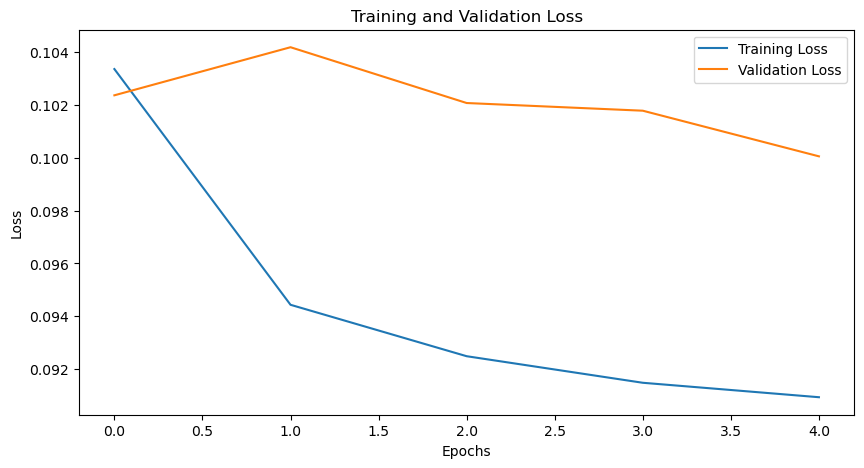

CPU times: user 34min 36s, sys: 3.64 s, total: 34min 39s
Wall time: 4min 39s


In [38]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [39]:
%%time
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

CPU times: user 6min 17s, sys: 672 ms, total: 6min 18s
Wall time: 20.3 s


In [40]:
%%time
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

CPU times: user 74.5 ms, sys: 0 ns, total: 74.5 ms
Wall time: 73.5 ms


In [41]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-3.36624789e+00, -3.94154608e-01, -3.18105072e-02,  2.20436239e+00,
          1.71855628e-01,  2.73041487e+00, -3.70409757e-01, -5.21993518e-01,
         -1.29841089e-01, -3.12201083e-02,  9.59733799e-02,  2.09692582e-01,
         -3.94596905e-01,  3.11172545e-01,  1.40349135e-01,  9.62093472e-02,
          8.81740153e-01, -2.58126020e-01,  1.93348780e-01,  1.21446274e-01,
         -8.03094581e-02, -1.73871189e-01, -1.68738499e-01, -3.95152092e+00,
         -1.80832267e-01,  2.90304160e+00, -1.40069388e-02, -3.29851896e-01,
         -3.10975108e-02, -1.72513515e-01, -2.26451512e-02,  6.94000959e-01,
         -1.96198523e-01, -1.25767618e-01,  1.10060386e-02,  3.22100431e-01,
         -8.28436464e-02, -7.84085691e-02, -3.62391353e-01, -2.23894924e-01,
          1.00729940e-02, -7.19170049e-02,  1.08666055e-01, -4.95809585e-01,
          1.32736713e-01,  3.06899518e-01, -1.43327546e+00, -7.19767883e-02,
          6.32872432e-02,  1.23443827e-01,  4.02199268e-01, -6.87

#### Cosine Similarity Matrix

In [42]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

CPU times: user 1.91 ms, sys: 0 ns, total: 1.91 ms
Wall time: 1.35 ms


array([[0.9999998 , 1.0000001 , 1.0000004 , ..., 1.0000001 , 1.0000001 ,
        0.99999994],
       [1.0000001 , 1.0000002 , 1.        , ..., 1.0000002 , 1.0000001 ,
        1.        ],
       [1.0000004 , 1.        , 1.0000002 , ..., 0.9999998 , 1.0000002 ,
        1.0000002 ],
       ...,
       [1.0000001 , 1.0000002 , 0.9999998 , ..., 0.99999994, 1.0000004 ,
        1.0000002 ],
       [1.0000001 , 1.0000001 , 1.0000002 , ..., 1.0000004 , 1.0000002 ,
        1.0000002 ],
       [0.99999994, 1.        , 1.0000002 , ..., 1.0000002 , 1.0000002 ,
        0.99999994]], dtype=float32)

#### 2-Train 10 Stocks

In [43]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Filter the first n stocks
n_stocks = 10  # Adjust n as needed
cleaned_data_n_stocks = filter_first_n_stocks(cleaned_data, n_stocks)

# Split data
train_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] <= "2023-09-30"]
validation_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 12823
Validation Dataset Length: 315
{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  2.0000e+00],
        ...,
        [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2500e+02],
        [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2600e+02],
        [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.2700e+02]]), 'target': tensor([0.0129, 0.0129, 0.3973, 0.3973, 0.0864, 0.0864, 0.0140, 0.0140, 0.0811,
        0.1040, 0.1251]), 'permno_id': '10104'}
CPU times: user 9.58 s, sys: 39.5 ms, total: 9.61 s
Wall time: 9.61 s


#### Build and Train Model

In [44]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

Starting Training...
Epoch 1/5 took 11.22 seconds
Epoch 1/5, Training Loss: 0.09676339500525646, Validation Loss: 0.05698540210723877
Epoch 2/5 took 11.22 seconds
Epoch 2/5, Training Loss: 0.07961457158599114, Validation Loss: 0.05407167188823223
Epoch 3/5 took 11.25 seconds
Epoch 3/5, Training Loss: 0.07619431380767774, Validation Loss: 0.05290775652974844
Epoch 4/5 took 11.28 seconds
Epoch 4/5, Training Loss: 0.07397042420643969, Validation Loss: 0.05419045481830835
Epoch 5/5 took 11.27 seconds
Epoch 5/5, Training Loss: 0.07243093006089887, Validation Loss: 0.05832871962338686
Training Complete


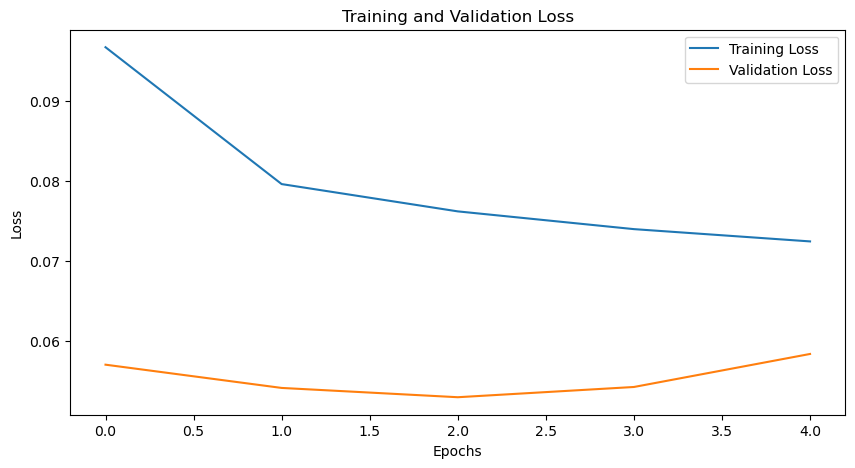

CPU times: user 6min 56s, sys: 1.45 s, total: 6min 57s
Wall time: 56.4 s


In [45]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [46]:
%%time
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

CPU times: user 1min 14s, sys: 134 ms, total: 1min 14s
Wall time: 3.95 s


In [47]:
%%time
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

CPU times: user 11.9 ms, sys: 3.97 ms, total: 15.9 ms
Wall time: 15 ms


In [48]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-1.57675874e+00, -2.62182385e-01, -8.61117303e-01, -2.25381064e+00,
          1.15086687e+00, -2.18486458e-01, -7.04462826e-01, -8.57300997e-01,
         -6.42241061e-01, -5.72957695e-01,  6.35950267e-01,  8.70929360e-01,
          5.94258368e-01, -4.45971787e-01,  8.96723151e-01,  5.21461070e-01,
         -8.82154346e-01,  1.38619274e-01,  7.86439359e-01,  6.27297580e-01,
          4.28564012e-01,  1.62530768e+00,  1.63931525e+00,  4.07939196e-01,
         -1.49625927e-01, -5.49903631e-01,  2.35728145e-01, -1.11187387e+00,
         -1.40264285e+00, -2.12668419e+00,  7.74603188e-02,  7.00539649e-01,
          3.99797857e-01, -2.46010110e-01, -5.39022923e-01,  8.08861256e-01,
          1.23448350e-01, -6.88028514e-01,  6.97489917e-01,  2.36190688e-02,
          6.93010211e-01,  8.10076118e-01, -2.39580750e-01, -5.10521173e-01,
         -3.01034904e+00, -6.40476167e-01, -3.78577262e-01, -1.05257258e-01,
          1.77915081e-01,  3.90308797e-01,  2.03142673e-01,  4.22

#### Cosine Similarity Matrix

In [49]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

CPU times: user 1.52 ms, sys: 19 μs, total: 1.54 ms
Wall time: 1.04 ms


array([[1.        , 0.99999946, 0.9999999 , 1.        , 1.0000002 ,
        1.        , 0.99998575, 1.0000001 , 0.99999994, 1.0000001 ],
       [0.99999946, 1.0000002 , 0.9999998 , 1.0000002 , 1.0000001 ,
        0.9999994 , 0.99998534, 0.9999998 , 1.0000001 , 1.0000002 ],
       [0.9999999 , 0.9999998 , 0.9999999 , 0.99999994, 0.9999999 ,
        1.0000001 , 0.9999859 , 0.9999998 , 0.9999999 , 1.        ],
       [1.        , 1.0000002 , 0.99999994, 1.0000002 , 0.9999998 ,
        1.0000001 , 0.99998575, 1.0000001 , 0.99999994, 0.9999995 ],
       [1.0000002 , 1.0000001 , 0.9999999 , 0.9999998 , 1.0000001 ,
        1.0000001 , 0.9999847 , 1.0000001 , 0.99999994, 0.99999964],
       [1.        , 0.9999994 , 1.0000001 , 1.0000001 , 1.0000001 ,
        1.0000004 , 0.999986  , 1.        , 0.9999999 , 0.9999997 ],
       [0.99998575, 0.99998534, 0.9999859 , 0.99998575, 0.9999847 ,
        0.999986  , 1.0000002 , 0.99998623, 0.99998504, 0.9999856 ],
       [1.0000001 , 0.9999998 , 0.9999998

#### 3-Train 100 Stocks

In [50]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Filter the first n stocks
n_stocks = 100  # Adjust n as needed
cleaned_data_n_stocks = filter_first_n_stocks(cleaned_data, n_stocks)

# Split data
train_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] <= "2023-09-30"]
validation_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 129414
Validation Dataset Length: 3360
{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  2.0000e+00],
        ...,
        [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2500e+02],
        [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2600e+02],
        [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.2700e+02]]), 'target': tensor([0.0129, 0.0129, 0.3973, 0.3973, 0.0864, 0.0864, 0.0140, 0.0140, 0.0811,
        0.1040, 0.1251]), 'permno_id': '10104'}
CPU times: user 1min 33s, sys: 13.3 s, total: 1min 46s
Wall time: 1min 46s


#### Build and Train Model

In [51]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

Starting Training...
Epoch 1/5 took 114.58 seconds
Epoch 1/5, Training Loss: 0.10283351010367808, Validation Loss: 0.11876772713093531
Epoch 2/5 took 113.98 seconds
Epoch 2/5, Training Loss: 0.09723340668042084, Validation Loss: 0.12736323674519856
Epoch 3/5 took 114.60 seconds
Epoch 3/5, Training Loss: 0.09624665458680894, Validation Loss: 0.13519201009046464
Epoch 4/5 took 114.06 seconds
Epoch 4/5, Training Loss: 0.09585445622541701, Validation Loss: 0.1170859904516311
Epoch 5/5 took 114.42 seconds
Epoch 5/5, Training Loss: 0.0955794228676002, Validation Loss: 0.1372298504625048
Training Complete


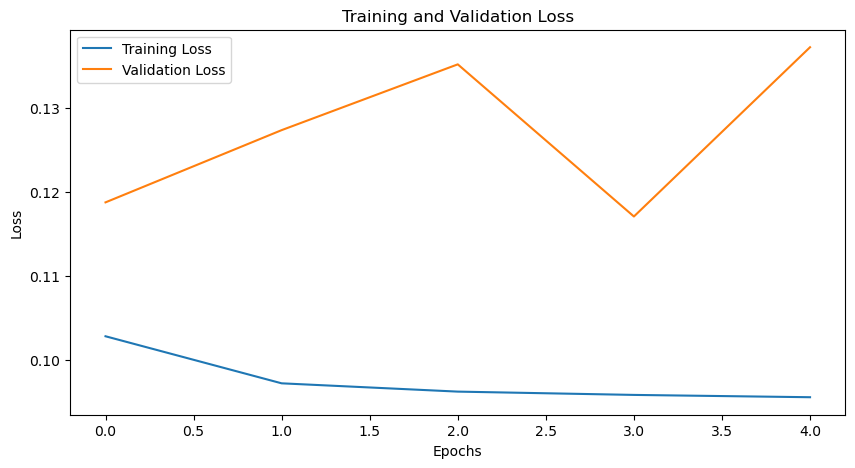

CPU times: user 1h 10min 30s, sys: 12.4 s, total: 1h 10min 42s
Wall time: 9min 31s


In [52]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [53]:
%%time
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

CPU times: user 12min 27s, sys: 1.56 s, total: 12min 29s
Wall time: 39.9 s


In [54]:
%%time
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

CPU times: user 159 ms, sys: 4.04 ms, total: 163 ms
Wall time: 162 ms


In [55]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 5.38896143e-01,  5.15447617e-01, -3.49517792e-01, -2.92236269e-01,
          5.84284663e-01, -7.48153269e-01, -1.45078075e+00, -1.77914113e-01,
         -1.92488924e-01, -3.46640766e-01, -2.14189261e-01, -3.58703583e-01,
          6.78312872e-03,  6.26967549e-01, -2.20369792e+00, -2.57958740e-01,
         -3.11187088e-01,  4.53923732e-01,  1.22099683e-01, -1.48010254e-01,
         -3.96399498e-01,  5.17843723e-01, -1.98014319e-01,  5.25106966e-01,
         -3.58429462e-01, -1.05499178e-01,  1.71921775e-01,  4.26763147e-01,
         -3.50797534e-01, -2.78167158e-01, -8.14209104e-01, -9.10155594e-01,
         -1.22521782e+00, -5.57783283e-02, -2.63092041e-01,  2.19510213e-01,
          4.72680777e-02,  1.10809013e-01,  1.53990582e-01,  3.22073430e-01,
          3.13262373e-01,  1.30967245e-01,  1.43222415e+00, -1.44484239e-02,
          1.97604194e-01,  4.76380885e-02,  5.55398941e-01, -2.36969304e+00,
          4.12603408e-01,  2.94919193e-01,  1.85757414e-01,  4.04

#### Cosine Similarity Matrix

In [56]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

CPU times: user 1.75 ms, sys: 15 μs, total: 1.76 ms
Wall time: 1.34 ms


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

#### 4-Train 200 Stocks

In [30]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Filter the first n stocks
n_stocks = 200  # Adjust n as needed
cleaned_data_n_stocks = filter_first_n_stocks(cleaned_data, n_stocks)

# Split data
train_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] <= "2023-09-30"]
validation_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 246265
Validation Dataset Length: 6790
{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  2.0000e+00],
        ...,
        [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2500e+02],
        [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2600e+02],
        [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.2700e+02]]), 'target': tensor([0.0129, 0.0129, 0.3973, 0.3973, 0.0864, 0.0864, 0.0140, 0.0140, 0.0811,
        0.1040, 0.1251]), 'permno_id': '10104'}
CPU times: user 2min 56s, sys: 59.4 s, total: 3min 55s
Wall time: 3min 55s


#### Build and Train Model

In [31]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

Starting Training...
Epoch 1/5 took 217.52 seconds
Epoch 1/5, Training Loss: 0.0976086250247856, Validation Loss: 0.09652933048110612
Epoch 2/5 took 218.28 seconds
Epoch 2/5, Training Loss: 0.09319140572195753, Validation Loss: 0.0843594560285969
Epoch 3/5 took 218.56 seconds
Epoch 3/5, Training Loss: 0.09273119284863353, Validation Loss: 0.08041379296443832
Epoch 4/5 took 217.76 seconds
Epoch 4/5, Training Loss: 0.09248566000626506, Validation Loss: 0.08013720303214213
Epoch 5/5 took 217.70 seconds
Epoch 5/5, Training Loss: 0.09231554461486266, Validation Loss: 0.0800528838321077
Training Complete


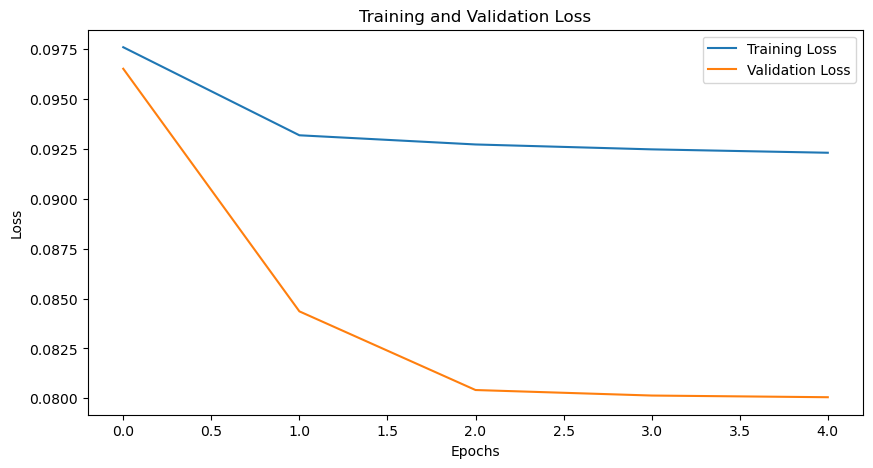

CPU times: user 2h 15min 36s, sys: 18.5 s, total: 2h 15min 54s
Wall time: 18min 11s


In [32]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [33]:
%%time
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

CPU times: user 24min 2s, sys: 3.4 s, total: 24min 6s
Wall time: 1min 17s


In [34]:
%%time
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

CPU times: user 334 ms, sys: 0 ns, total: 334 ms
Wall time: 334 ms


In [35]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-2.06128502e+00,  1.37221009e-01, -3.80127215e+00,  1.00411065e-01,
         -1.15243904e-02, -3.17775272e-02,  1.28005713e-01, -7.52942443e-01,
         -1.33659095e-02,  1.85847413e-02, -5.61879203e-02, -3.83978225e-02,
          1.86327528e-02,  5.50233945e-02, -1.95140932e-02, -1.22171372e-01,
          4.24794182e-02, -7.31792152e-02, -9.23095793e-02,  2.91599333e-03,
          2.23693624e-03, -4.64431830e-02,  5.91988675e-02,  7.94982985e-02,
          7.70951807e-02,  4.92562577e-02,  8.18934739e-02,  1.05287403e-01,
          1.28938898e-03,  8.98361579e-02,  2.50510871e-02, -6.96849078e-02,
          6.99844733e-02, -3.55391097e+00,  1.33062184e-01,  1.11022614e-01,
         -4.41979058e-02, -7.07957596e-02, -1.62212506e-01, -8.80661383e-02,
          6.55459613e-03, -5.64752668e-02, -1.41315144e-02,  2.37451913e-03,
          1.07515383e+00, -2.72531230e-02, -8.63032714e-02,  1.40974700e-01,
          1.21504299e-01, -2.61384193e-02, -2.22382694e-02,  1.62

#### Cosine Similarity Matrix

In [36]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

CPU times: user 2.52 ms, sys: 25 μs, total: 2.54 ms
Wall time: 2.77 ms


array([[0.9999996, 0.9999996, 0.9999996, ..., 0.9999996, 0.9999996,
        0.9999996],
       [0.9999996, 0.9999996, 0.9999996, ..., 0.9999996, 0.9999996,
        0.9999996],
       [0.9999996, 0.9999996, 0.9999996, ..., 0.9999996, 0.9999996,
        0.9999996],
       ...,
       [0.9999996, 0.9999996, 0.9999996, ..., 0.9999996, 0.9999996,
        0.9999996],
       [0.9999996, 0.9999996, 0.9999996, ..., 0.9999996, 0.9999996,
        0.9999996],
       [0.9999996, 0.9999996, 0.9999996, ..., 0.9999996, 0.9999996,
        0.9999996]], dtype=float32)

### Case 1: Model-new__getitem__1 (128 days, 7 features and 11 targets)
Features:  
'log_return'  
'postional encoding'  
"sector_weighted_avg_log_return"  
"sector_simple_avg_log_return"  
"weighted_avg_log_return"  
"simple_avg_log_return"  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Labels:
"log_return"  
"abs_log_return"  
"log_return_7"  
"abs_log_return_7"  
"log_return_14"  
"abs_log_return_14"  
"log_return_28"  
"abs_log_return_28"  
"volatility_7"  
"volatility_14"  
"volatility_28"

#### Create Dataset

In [37]:
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data["positional_encoding"] = self.data.groupby("permno_id").cumcount()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.group_length = {
            name: len(group) - self.window_size for name, group in self.groups if len(group) > self.window_size
        }  # ["12": 882, "13": 882, 882, 501, ...., 882]
        self.length = sum(self.group_length.values())

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        current_idx = idx
        for name, group in self.groups:
            if len(group) > self.window_size:
                if current_idx < len(group) - self.window_size:
                    i = current_idx
                    permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
                    X = group[self.input_columns].iloc[i : i + self.window_size].values
                    X = np.concatenate(
                        [X, permno_id_one_hot[i : i + self.window_size]], axis=1
                    )  # Concatenate one-hot encoded permno_id
                    X = np.concatenate(
                        [X, group["positional_encoding"].iloc[i : i + self.window_size].values.reshape(-1, 1)], axis=1
                    )
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    return {
                        "features": torch.tensor(X, dtype=torch.float),
                        "target": torch.tensor(y, dtype=torch.float),
                        "permno_id": name,
                    }
                else:
                    current_idx -= len(group) - self.window_size

#### 1-Train 20 Stocks

In [46]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Filter the first n stocks
n_stocks = 20  # Adjust n as needed
cleaned_data_n_stocks = filter_first_n_stocks(cleaned_data, n_stocks)

# Split data
train_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] <= "2023-09-30"]
validation_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 24452
Validation Dataset Length: 595
{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  2.0000e+00],
        ...,
        [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2500e+02],
        [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2600e+02],
        [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.2700e+02]]), 'target': tensor([0.0129, 0.0129, 0.3973, 0.3973, 0.0864, 0.0864, 0.0140, 0.0140, 0.0811,
        0.1040, 0.1251]), 'permno_id': '10104'}
CPU times: user 261 ms, sys: 0 ns, total: 261 ms
Wall time: 252 ms


In [47]:
# %%time
# # Prepare Data

# # Ensure the data is sorted by date for each permno_id
# cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# # First, apply the OneHotEncoder to the entire dataset
# cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoder.fit(cleaned_data[["permno_id"]])

# # Split data
# train_data = cleaned_data[cleaned_data["date"] <= "2023-09-30"]
# validation_data = cleaned_data[cleaned_data["date"] > "2023-09-30"]

# # Find the last 128 rows for each permno_id in train_data and add them to validation_data
# last_128_rows = train_data.groupby("permno_id").tail(128)

# # Include these rows in validation_data
# validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# # Create datasets
# train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
# val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# # Print the length of datasets to ensure correctness
# print(f"Train Dataset Length: {len(train_dataset)}")
# print(f"Validation Dataset Length: {len(val_dataset)}")

# # Fetch a single item to check correctness
# sample_item = train_dataset[0]
# print(sample_item)

#### Build and Train Model

In [48]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        # x ~ (None, 128, 560 (7 + 553)
        x = self.embedding(x)  # (None, 128, 560) ->  (None, 128, 256)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

Starting Training...
Batch 0, Loss: 0.11175813525915146, train_loss: 0.11175813525915146
Epoch 1/2 took 143.43 seconds
Epoch 1/2, Training Loss: 0.09566355824373127, Validation Loss: 0.06704393989945713
Batch 0, Loss: 0.0409870445728302, train_loss: 0.0409870445728302
Epoch 2/2 took 143.65 seconds
Epoch 2/2, Training Loss: 0.08243265846878095, Validation Loss: 0.06736172147487339
Early stopping triggered.
Training Complete


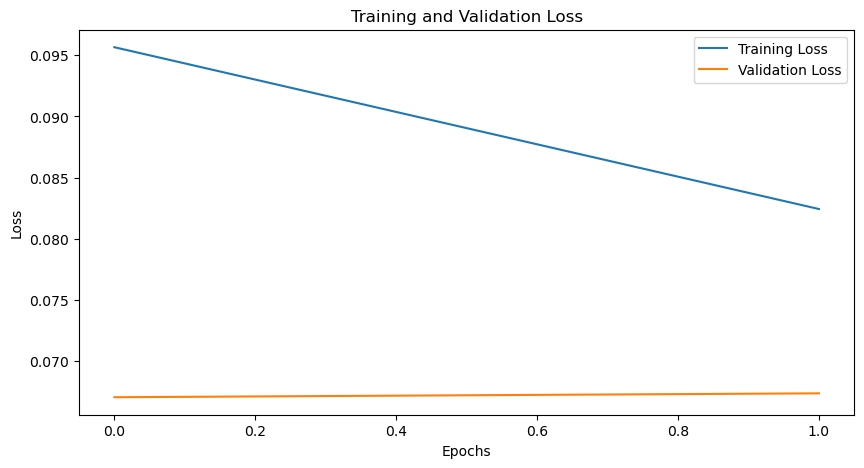

CPU times: user 1h 39min 34s, sys: 1.25 s, total: 1h 39min 35s
Wall time: 4min 47s


In [49]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    hidden_dims=[256, 128],
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 2
patience = 1
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10000 == 0:
            print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
            # if i % 20 == 0:
            #     print(f"Batch {i}, Loss: {loss}, val_loss: {val_loss}")

    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [ ]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [ ]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [ ]:
list(stock_embeddings.items())[:2]

#### Cosine Similarity Matrix

In [ ]:
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

#### Model Features Check

In [75]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5

In [76]:
batch["features"].shape

torch.Size([32, 128, 560])

In [77]:
batch["target"].shape

torch.Size([32, 11])

In [78]:
len(batch["permno_id"])

32

In [79]:
batch["features"][:5]

tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5.1301e-03, -5

In [80]:
model(batch["features"].to(device))

(tensor([[-0.0300,  0.0192,  0.0604,  0.0808,  0.0161,  0.0663,  0.0246,  0.0071,
           0.1666,  0.1783,  0.1594],
         [-0.0295,  0.0190,  0.0601,  0.0813,  0.0159,  0.0662,  0.0245,  0.0071,
           0.1667,  0.1789,  0.1595],
         [-0.0291,  0.0188,  0.0599,  0.0818,  0.0157,  0.0661,  0.0243,  0.0070,
           0.1668,  0.1794,  0.1596],
         [-0.0287,  0.0186,  0.0597,  0.0822,  0.0156,  0.0661,  0.0242,  0.0070,
           0.1668,  0.1799,  0.1596],
         [-0.0284,  0.0184,  0.0596,  0.0826,  0.0154,  0.0660,  0.0241,  0.0069,
           0.1669,  0.1803,  0.1596],
         [-0.0280,  0.0182,  0.0594,  0.0830,  0.0153,  0.0659,  0.0239,  0.0069,
           0.1669,  0.1808,  0.1597],
         [-0.0277,  0.0180,  0.0593,  0.0834,  0.0152,  0.0659,  0.0238,  0.0069,
           0.1669,  0.1812,  0.1597],
         [-0.0274,  0.0179,  0.0592,  0.0838,  0.0151,  0.0658,  0.0237,  0.0068,
           0.1669,  0.1816,  0.1597],
         [-0.0271,  0.0177,  0.0590,  0.

In [81]:
# train_dataset.sequences[-5:]

In [82]:
np.array(stock_embeddings["10104"]).shape

(256,)

#### 2-Train 50 Stocks

In [50]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Filter the first n stocks
n_stocks = 50  # Adjust n as needed
cleaned_data_n_stocks = filter_first_n_stocks(cleaned_data, n_stocks)

# Split data
train_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] <= "2023-09-30"]
validation_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 63514
Validation Dataset Length: 1610
{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  2.0000e+00],
        ...,
        [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2500e+02],
        [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2600e+02],
        [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.2700e+02]]), 'target': tensor([0.0129, 0.0129, 0.3973, 0.3973, 0.0864, 0.0864, 0.0140, 0.0140, 0.0811,
        0.1040, 0.1251]), 'permno_id': '10104'}
CPU times: user 293 ms, sys: 0 ns, total: 293 ms
Wall time: 290 ms


In [51]:
# %%time
# # Prepare Data

# # Ensure the data is sorted by date for each permno_id
# cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# # First, apply the OneHotEncoder to the entire dataset
# cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoder.fit(cleaned_data[["permno_id"]])

# # Split data
# train_data = cleaned_data[cleaned_data["date"] <= "2023-09-30"]
# validation_data = cleaned_data[cleaned_data["date"] > "2023-09-30"]

# # Find the last 128 rows for each permno_id in train_data and add them to validation_data
# last_128_rows = train_data.groupby("permno_id").tail(128)

# # Include these rows in validation_data
# validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# # Create datasets
# train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
# val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# # Print the length of datasets to ensure correctness
# print(f"Train Dataset Length: {len(train_dataset)}")
# print(f"Validation Dataset Length: {len(val_dataset)}")

# # Fetch a single item to check correctness
# sample_item = train_dataset[0]
# print(sample_item)

#### Build and Train Model

In [52]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        # x ~ (None, 128, 560 (7 + 553)
        x = self.embedding(x)  # (None, 128, 560) ->  (None, 128, 256)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

Starting Training...
Batch 0, Loss: 0.17397326231002808, train_loss: 0.17397326231002808
Epoch 1/2 took 551.35 seconds
Epoch 1/2, Training Loss: 0.1061538988794728, Validation Loss: 0.10371478603166692
Batch 0, Loss: 0.1350967437028885, train_loss: 0.1350967437028885
Epoch 2/2 took 551.11 seconds
Epoch 2/2, Training Loss: 0.09469180879387207, Validation Loss: 0.10613630302980834
Early stopping triggered.
Training Complete


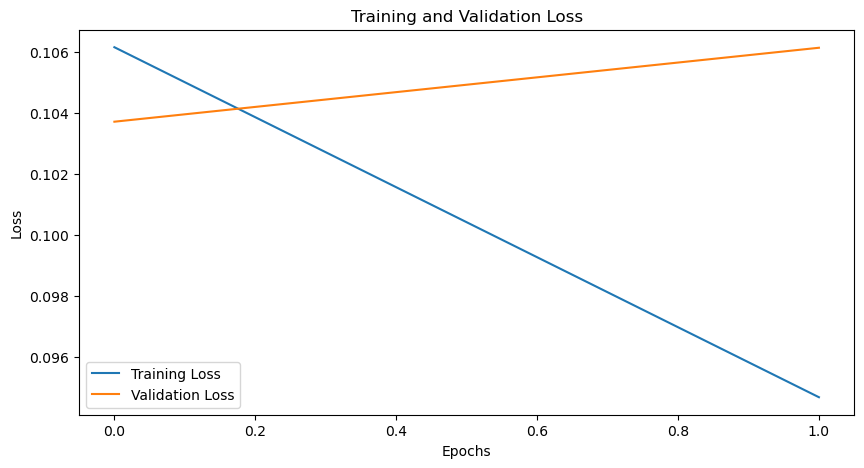

CPU times: user 5h 24min 8s, sys: 36.9 s, total: 5h 24min 45s
Wall time: 18min 22s


In [53]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    hidden_dims=[256, 128],
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 2
patience = 1
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10000 == 0:
            print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
            # if i % 20 == 0:
            #     print(f"Batch {i}, Loss: {loss}, val_loss: {val_loss}")

    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### 3-Train 100 Stocks

In [54]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Filter the first n stocks
n_stocks = 100  # Adjust n as needed
cleaned_data_n_stocks = filter_first_n_stocks(cleaned_data, n_stocks)

# Split data
train_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] <= "2023-09-30"]
validation_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 129414
Validation Dataset Length: 3360
{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  2.0000e+00],
        ...,
        [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2500e+02],
        [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2600e+02],
        [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.2700e+02]]), 'target': tensor([0.0129, 0.0129, 0.3973, 0.3973, 0.0864, 0.0864, 0.0140, 0.0140, 0.0811,
        0.1040, 0.1251]), 'permno_id': '10104'}
CPU times: user 397 ms, sys: 0 ns, total: 397 ms
Wall time: 378 ms


In [55]:
# %%time
# # Prepare Data

# # Ensure the data is sorted by date for each permno_id
# cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# # First, apply the OneHotEncoder to the entire dataset
# cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoder.fit(cleaned_data[["permno_id"]])

# # Split data
# train_data = cleaned_data[cleaned_data["date"] <= "2023-09-30"]
# validation_data = cleaned_data[cleaned_data["date"] > "2023-09-30"]

# # Find the last 128 rows for each permno_id in train_data and add them to validation_data
# last_128_rows = train_data.groupby("permno_id").tail(128)

# # Include these rows in validation_data
# validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# # Create datasets
# train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
# val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# # Print the length of datasets to ensure correctness
# print(f"Train Dataset Length: {len(train_dataset)}")
# print(f"Validation Dataset Length: {len(val_dataset)}")

# # Fetch a single item to check correctness
# sample_item = train_dataset[0]
# print(sample_item)

#### Build and Train Model

In [56]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        # x ~ (None, 128, 560 (7 + 553)
        x = self.embedding(x)  # (None, 128, 560) ->  (None, 128, 256)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

Starting Training...
Batch 0, Loss: 0.13026489317417145, train_loss: 0.13026489317417145
Epoch 1/2 took 1584.62 seconds
Epoch 1/2, Training Loss: 0.10415342254207294, Validation Loss: 0.15237281982387815
Batch 0, Loss: 0.1982164829969406, train_loss: 0.1982164829969406
Epoch 2/2 took 1580.85 seconds
Epoch 2/2, Training Loss: 0.09766129114848132, Validation Loss: 0.1194225407072476
Training Complete


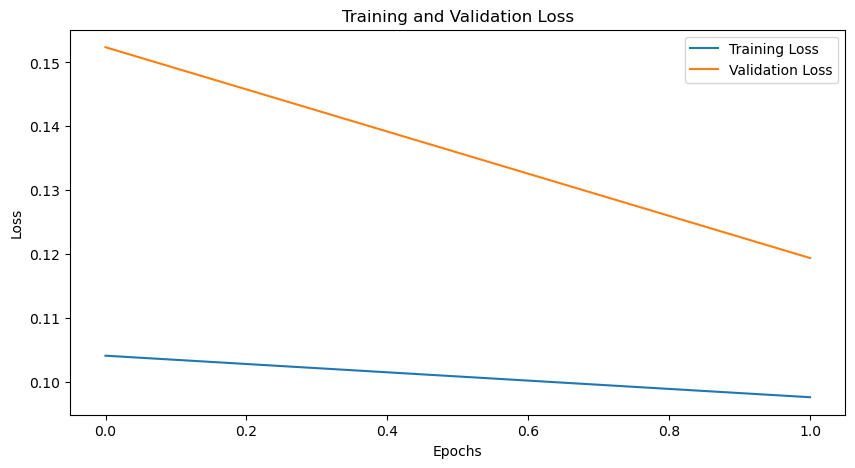

CPU times: user 11h 22min 25s, sys: 1min 29s, total: 11h 23min 54s
Wall time: 52min 45s


In [57]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    hidden_dims=[256, 128],
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 2
patience = 1
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10000 == 0:
            print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
            # if i % 20 == 0:
            #     print(f"Batch {i}, Loss: {loss}, val_loss: {val_loss}")

    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### 4-Train 200 Stocks

In [69]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Filter the first n stocks
n_stocks = 200  # Adjust n as needed
cleaned_data_n_stocks = filter_first_n_stocks(cleaned_data, n_stocks)

# Split data
train_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] <= "2023-09-30"]
validation_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 246265
Validation Dataset Length: 6790
{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  2.0000e+00],
        ...,
        [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2500e+02],
        [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2600e+02],
        [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.2700e+02]]), 'target': tensor([0.0129, 0.0129, 0.3973, 0.3973, 0.0864, 0.0864, 0.0140, 0.0140, 0.0811,
        0.1040, 0.1251]), 'permno_id': '10104'}
CPU times: user 545 ms, sys: 0 ns, total: 545 ms
Wall time: 536 ms


In [70]:
# %%time
# # Prepare Data

# # Ensure the data is sorted by date for each permno_id
# cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# # First, apply the OneHotEncoder to the entire dataset
# cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoder.fit(cleaned_data[["permno_id"]])

# # Split data
# train_data = cleaned_data[cleaned_data["date"] <= "2023-09-30"]
# validation_data = cleaned_data[cleaned_data["date"] > "2023-09-30"]

# # Find the last 128 rows for each permno_id in train_data and add them to validation_data
# last_128_rows = train_data.groupby("permno_id").tail(128)

# # Include these rows in validation_data
# validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# # Create datasets
# train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
# val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# # Print the length of datasets to ensure correctness
# print(f"Train Dataset Length: {len(train_dataset)}")
# print(f"Validation Dataset Length: {len(val_dataset)}")

# # Fetch a single item to check correctness
# sample_item = train_dataset[0]
# print(sample_item)

#### Build and Train Model

In [71]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        # x ~ (None, 128, 560 (7 + 553)
        x = self.embedding(x)  # (None, 128, 560) ->  (None, 128, 256)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

In [74]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    hidden_dims=[256, 128],
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 2
patience = 1
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
total_batches = num_epochs * len(train_dataloader)
total_start_time = time.time()

for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    batch_start_time = time.time()
    
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 20 == 0:
            # print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
            elapsed_time = time.time() - batch_start_time
            remaining_batches = len(train_dataloader) - (i + 1)
            estimated_remaining_time_epoch = remaining_batches * (elapsed_time / (i + 1))
            
            total_elapsed_time = time.time() - total_start_time
            total_remaining_batches = total_batches - ((epoch * len(train_dataloader)) + (i + 1))
            estimated_remaining_time_total = total_remaining_batches * (total_elapsed_time / ((epoch * len(train_dataloader)) + (i + 1)))

            print(f"Batch {i}/{len(train_dataloader)}, Loss: {loss:.4f}, train_loss: {running_loss:.4f}, "
                  f"Estimated time left for epoch: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_epoch))}, "
                  f"Estimated time left for training: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_total))}")
            
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
            # if i % 20 == 0:
            #     print(f"Batch {i}, Loss: {loss}, val_loss: {val_loss}")

    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Starting Training...
Batch 0/7696, Loss: 0.1829, train_loss: 0.1829, Estimated time left for epoch: 01:07:58, Estimated time left for training: 02:16:02
Batch 20/7696, Loss: 0.2362, train_loss: 4.5817, Estimated time left for epoch: 01:07:17, Estimated time left for training: 02:14:46
Batch 40/7696, Loss: 0.1891, train_loss: 8.0505, Estimated time left for epoch: 01:07:06, Estimated time left for training: 02:14:34
Batch 60/7696, Loss: 0.0791, train_loss: 10.3988, Estimated time left for epoch: 01:07:01, Estimated time left for training: 02:14:35
Batch 80/7696, Loss: 0.0810, train_loss: 12.3929, Estimated time left for epoch: 01:06:52, Estimated time left for training: 02:14:28
Batch 100/7696, Loss: 0.1187, train_loss: 14.4516, Estimated time left for epoch: 01:06:42, Estimated time left for training: 02:14:18
Batch 120/7696, Loss: 0.0753, train_loss: 16.4685, Estimated time left for epoch: 01:06:33, Estimated time left for training: 02:14:10
Batch 140/7696, Loss: 0.0770, train_loss: 1

KeyboardInterrupt: 

#### 5-Train All S&P 500 Stocks

In [75]:
# %%time
# # Prepare Data

# # Ensure the data is sorted by date for each permno_id
# cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# # First, apply the OneHotEncoder to the entire dataset
# cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoder.fit(cleaned_data[["permno_id"]])

# # Filter the first n stocks
# n_stocks = 200  # Adjust n as needed
# cleaned_data_n_stocks = filter_first_n_stocks(cleaned_data, n_stocks)

# # Split data
# train_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] <= "2023-09-30"]
# validation_data = cleaned_data_n_stocks[cleaned_data_n_stocks["date"] > "2023-09-30"]

# # Find the last 128 rows for each permno_id in train_data and add them to validation_data
# last_128_rows = train_data.groupby("permno_id").tail(128)

# # Include these rows in validation_data
# validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# # Create datasets
# train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
# val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# # Print the length of datasets to ensure correctness
# print(f"Train Dataset Length: {len(train_dataset)}")
# print(f"Validation Dataset Length: {len(val_dataset)}")

# # Fetch a single item to check correctness
# sample_item = train_dataset[0]
# print(sample_item)

In [76]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2023-09-30"]
validation_data = cleaned_data[cleaned_data["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 704674
Validation Dataset Length: 18785
{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  2.0000e+00],
        ...,
        [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2500e+02],
        [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2600e+02],
        [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.2700e+02]]), 'target': tensor([0.0129, 0.0129, 0.3973, 0.3973, 0.0864, 0.0864, 0.0140, 0.0140, 0.0811,
        0.1040, 0.1251]), 'permno_id': '10104'}
CPU times: user 1.08 s, sys: 0 ns, total: 1.08 s
Wall time: 1.07 s


#### Build and Train Model

In [77]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        # x ~ (None, 128, 560 (7 + 553)
        x = self.embedding(x)  # (None, 128, 560) ->  (None, 128, 256)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

In [78]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    hidden_dims=[256, 128],
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 2
patience = 1
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
total_batches = num_epochs * len(train_dataloader)
total_start_time = time.time()

for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    batch_start_time = time.time()
    
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 20 == 0:
            # print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
            elapsed_time = time.time() - batch_start_time
            remaining_batches = len(train_dataloader) - (i + 1)
            estimated_remaining_time_epoch = remaining_batches * (elapsed_time / (i + 1))
            
            total_elapsed_time = time.time() - total_start_time
            total_remaining_batches = total_batches - ((epoch * len(train_dataloader)) + (i + 1))
            estimated_remaining_time_total = total_remaining_batches * (total_elapsed_time / ((epoch * len(train_dataloader)) + (i + 1)))

            print(f"Batch {i}/{len(train_dataloader)}, Loss: {loss:.4f}, train_loss: {running_loss:.4f}, "
                  f"Estimated time left for epoch: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_epoch))}, "
                  f"Estimated time left for training: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_total))}")
            
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
            # if i % 20 == 0:
            #     print(f"Batch {i}, Loss: {loss}, val_loss: {val_loss}")

    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Starting Training...
Batch 0/22022, Loss: 0.1517, train_loss: 0.1517, Estimated time left for epoch: 07:28:29, Estimated time left for training: 14:57:12
Batch 20/22022, Loss: 0.2155, train_loss: 4.0335, Estimated time left for epoch: 07:28:13, Estimated time left for training: 14:56:52


KeyboardInterrupt: 

### Case 2: Model-new__getitem__2 (128 days, 7 features and 11 targets)
Features:  
'log_return'  
'postional encoding'  
"sector_weighted_avg_log_return"  
"sector_simple_avg_log_return"  
"weighted_avg_log_return"  
"simple_avg_log_return"  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Labels:
"log_return"  
"abs_log_return"  
"log_return_7"  
"abs_log_return_7"  
"log_return_14"  
"abs_log_return_14"  
"log_return_28"  
"abs_log_return_28"  
"volatility_7"  
"volatility_14"  
"volatility_28"

#### Create Dataset

In [26]:
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data["positional_encoding"] = self.data.groupby("permno_id").cumcount()

        # Group by permno_id
        self.groups = list(self.data.groupby("permno_id"))
        self.group_length = {
            name: len(group) - self.window_size for name, group in self.groups if len(group) > self.window_size
        }
        self.length = sum(self.group_length.values())

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        current_idx = idx
        for group_index, (name, current_group_length) in enumerate(self.group_length.items()):
            if current_idx >= current_group_length:
                current_idx -= current_group_length
                continue

            # this is the group i'm interested in!
            i = current_idx
            group = self.groups[group_index][1]  # Access the group by index

            # extract the data for the ith window from the current group
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            X = group[self.input_columns].iloc[i : i + self.window_size].values
            X = np.concatenate(
                [X, permno_id_one_hot[i : i + self.window_size]], axis=1
            )  # Concatenate one-hot encoded permno_id
            X = np.concatenate(
                [X, group["positional_encoding"].iloc[i : i + self.window_size].values.reshape(-1, 1)], axis=1
            )
            y = group[self.target_columns].iloc[i + self.window_size].values

            return {
                "features": torch.tensor(X, dtype=torch.float),
                "target": torch.tensor(y, dtype=torch.float),
                "permno_id": name,
            }

In [27]:
# %%time
# # Prepare Data

# # First, apply the OneHotEncoder to the entire dataset
# cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoder.fit(cleaned_data[["permno_id"]])

# # Split data
# train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
# validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

# # Create datasets
# train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
# val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [28]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2023-09-30"][:10000]
validation_data = cleaned_data[cleaned_data["date"] > "2023-09-30"][:1000]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 8976
Validation Dataset Length: 245
{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  2.0000e+00],
        ...,
        [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2500e+02],
        [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2600e+02],
        [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.2700e+02]]), 'target': tensor([0.0129, 0.0129, 0.3973, 0.3973, 0.0864, 0.0864, 0.0140, 0.0140, 0.0811,
        0.1040, 0.1251]), 'permno_id': '10104'}
CPU times: user 269 ms, sys: 0 ns, total: 269 ms
Wall time: 227 ms


#### Build and Train Model

In [29]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        # x ~ (None, 128, 560 (7 + 553)
        x = self.embedding(x)  # (None, 128, 560) ->  (None, 128, 256)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

In [30]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    hidden_dims=[256, 128],
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 0:
            print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
            # if i % 20 == 0:
            #     print(f"Batch {i}, Loss: {loss}, val_loss: {val_loss}")

    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Starting Training...
Batch 0, Loss: 0.108280248939991, train_loss: 0.108280248939991
Batch 200, Loss: 0.06300024688243866, train_loss: 19.536956880241632


IndexError: single positional indexer is out-of-bounds

#### Stock Embedding

In [74]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

KeyboardInterrupt: 

In [ ]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [ ]:
list(stock_embeddings.items())[:2]

#### Cosine Similarity Matrix

In [ ]:
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

#### Model Features Check

In [92]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5

In [93]:
batch["features"].shape

torch.Size([32, 128, 560])

In [94]:
batch["target"].shape

torch.Size([32, 11])

In [95]:
len(batch["permno_id"])

32

In [96]:
batch["features"][:5]

tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5.1301e-03, -5

In [97]:
model(batch["features"].to(device))

(tensor([[0.0028, 0.0089, 0.0225, 0.1116, 0.0209, 0.0207, 0.0041, 0.0094, 0.1427,
          0.1889, 0.1959],
         [0.0027, 0.0088, 0.0225, 0.1112, 0.0208, 0.0207, 0.0042, 0.0095, 0.1427,
          0.1890, 0.1959],
         [0.0026, 0.0087, 0.0225, 0.1109, 0.0209, 0.0207, 0.0043, 0.0097, 0.1427,
          0.1891, 0.1959],
         [0.0025, 0.0085, 0.0225, 0.1106, 0.0209, 0.0207, 0.0044, 0.0098, 0.1427,
          0.1891, 0.1959],
         [0.0023, 0.0084, 0.0225, 0.1104, 0.0209, 0.0207, 0.0045, 0.0099, 0.1426,
          0.1892, 0.1959],
         [0.0022, 0.0082, 0.0225, 0.1101, 0.0210, 0.0207, 0.0045, 0.0101, 0.1426,
          0.1892, 0.1959],
         [0.0020, 0.0082, 0.0225, 0.1099, 0.0210, 0.0206, 0.0046, 0.0102, 0.1425,
          0.1892, 0.1959],
         [0.0019, 0.0081, 0.0225, 0.1096, 0.0211, 0.0206, 0.0046, 0.0104, 0.1425,
          0.1893, 0.1959],
         [0.0018, 0.0080, 0.0224, 0.1094, 0.0212, 0.0206, 0.0047, 0.0105, 0.1424,
          0.1893, 0.1959],
         [0.0017, 0

In [98]:
# train_dataset.sequences[-5:]

In [99]:
np.array(stock_embeddings["10104"]).shape

(256,)

### Case 3: Model-new__getitem__3 (128 days, 7 features and 11 targets)
Features:  
'log_return'  
'postional encoding'  
"sector_weighted_avg_log_return"  
"sector_simple_avg_log_return"  
"weighted_avg_log_return"  
"simple_avg_log_return"  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Labels:
"log_return"  
"abs_log_return"  
"log_return_7"  
"abs_log_return_7"  
"log_return_14"  
"abs_log_return_14"  
"log_return_28"  
"abs_log_return_28"  
"volatility_7"  
"volatility_14"  
"volatility_28"

#### Create Dataset

In [37]:
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data["positional_encoding"] = self.data.groupby("permno_id").cumcount()

        # Precompute windows
        self.windows = []
        for name, group in self.data.groupby("permno_id"):
            group_length = len(group) - self.window_size
            if group_length > 0:
                for i in range(group_length):
                    self.windows.append((group, i, name))
        
        self.length = len(self.windows)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        group, i, name = self.windows[idx]

        # Precomputed one-hot encoding for this group
        permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
        
        # Extract the data for the ith window from the current group
        X = group[self.input_columns].iloc[i : i + self.window_size].values
        X = np.concatenate(
            [X, permno_id_one_hot[i : i + self.window_size]], axis=1
        )  # Concatenate one-hot encoded permno_id
        X = np.concatenate(
            [X, group["positional_encoding"].iloc[i : i + self.window_size].values.reshape(-1, 1)], axis=1
        )
        y = group[self.target_columns].iloc[i + self.window_size].values

        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": name,
        }


In [38]:
# %%time
# # Prepare Data

# # First, apply the OneHotEncoder to the entire dataset
# cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoder.fit(cleaned_data[["permno_id"]])

# # Split data
# train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
# validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

# # Create datasets
# train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
# val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [42]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2023-09-30"][:1000]
validation_data = cleaned_data[cleaned_data["date"] > "2023-09-30"][:1000]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 872
Validation Dataset Length: 35
{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  2.0000e+00],
        ...,
        [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2500e+02],
        [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2600e+02],
        [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.2700e+02]]), 'target': tensor([0.0129, 0.0129, 0.3973, 0.3973, 0.0864, 0.0864, 0.0140, 0.0140, 0.0811,
        0.1040, 0.1251]), 'permno_id': '10104'}
CPU times: user 187 ms, sys: 12.2 ms, total: 200 ms
Wall time: 190 ms


#### Build and Train Model

In [43]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        # x ~ (None, 128, 560 (7 + 553)
        x = self.embedding(x)  # (None, 128, 560) ->  (None, 128, 256)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

Starting Training...
Batch 0, Loss: 0.10849661380052567, train_loss: 0.10849661380052567
Epoch 1/5 took 20.45 seconds
Epoch 1/5, Training Loss: 0.1348807370024068, Validation Loss: 0.08726345375180244
Batch 0, Loss: 0.0827748253941536, train_loss: 0.0827748253941536
Epoch 2/5 took 20.52 seconds
Epoch 2/5, Training Loss: 0.10697918039347444, Validation Loss: 0.07154358178377151
Batch 0, Loss: 0.0732186958193779, train_loss: 0.0732186958193779
Epoch 3/5 took 20.63 seconds
Epoch 3/5, Training Loss: 0.09683812955128294, Validation Loss: 0.06552331522107124
Batch 0, Loss: 0.06801658868789673, train_loss: 0.06801658868789673
Epoch 4/5 took 20.44 seconds
Epoch 4/5, Training Loss: 0.09327469140823398, Validation Loss: 0.06592895835638046
Batch 0, Loss: 0.06459281593561172, train_loss: 0.06459281593561172
Epoch 5/5 took 20.13 seconds
Epoch 5/5, Training Loss: 0.08937340549060277, Validation Loss: 0.06445097364485264
Training Complete


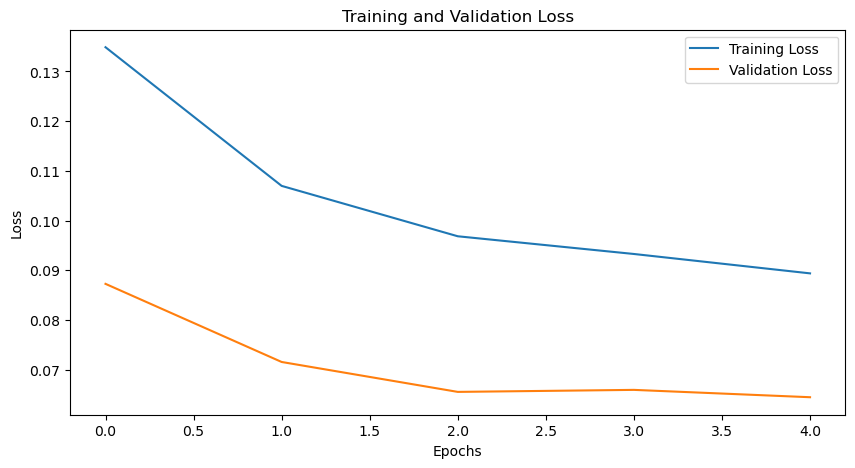

CPU times: user 12min 51s, sys: 47.6 s, total: 13min 38s
Wall time: 1min 42s


In [44]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    hidden_dims=[256, 128],
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 0:
            print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
            # if i % 20 == 0:
            #     print(f"Batch {i}, Loss: {loss}, val_loss: {val_loss}")

    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [88]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [89]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [90]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-3.78572136e-01,  4.02556390e-01,  4.87570375e-01, -9.71987426e-01,
          1.54144049e+00, -3.19399774e-01,  2.12927198e+00, -9.93603375e-03,
         -7.25138724e-01, -1.75474293e-03, -3.52325410e-01, -6.04183018e-01,
         -3.14344913e-01,  8.13303053e-01,  1.71755746e-01,  3.56624603e-01,
         -2.89752632e-01, -1.84308982e+00,  5.91277927e-02,  2.29618454e+00,
          1.16721559e+00, -1.79804754e+00, -1.54913947e-01, -3.25009853e-01,
          3.89528602e-01, -7.40367651e-01,  9.27669883e-01, -8.65040064e-01,
          1.18745551e-01,  7.20537126e-01,  2.93112785e-01,  7.18086898e-01,
          6.01840876e-02, -8.33960176e-01, -1.87334335e+00,  8.47103179e-01,
         -2.39123726e+00, -2.19618782e-01, -3.35128307e-01, -5.18376648e-01,
         -5.38411558e-01, -1.18982148e+00,  1.11462069e+00,  2.52209306e-01,
          1.06397140e+00, -9.44217205e-01,  4.28313375e-01, -1.58407426e+00,
          2.26807535e-01,  3.56458902e-01, -1.49498731e-01, -3.11

#### Cosine Similarity Matrix

In [91]:
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[1.0000001]], dtype=float32)

#### Model Features Check

In [92]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5

In [93]:
batch["features"].shape

torch.Size([32, 128, 560])

In [94]:
batch["target"].shape

torch.Size([32, 11])

In [95]:
len(batch["permno_id"])

32

In [96]:
batch["features"][:5]

tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5.1301e-03, -5

In [97]:
model(batch["features"].to(device))

(tensor([[0.0028, 0.0089, 0.0225, 0.1116, 0.0209, 0.0207, 0.0041, 0.0094, 0.1427,
          0.1889, 0.1959],
         [0.0027, 0.0088, 0.0225, 0.1112, 0.0208, 0.0207, 0.0042, 0.0095, 0.1427,
          0.1890, 0.1959],
         [0.0026, 0.0087, 0.0225, 0.1109, 0.0209, 0.0207, 0.0043, 0.0097, 0.1427,
          0.1891, 0.1959],
         [0.0025, 0.0085, 0.0225, 0.1106, 0.0209, 0.0207, 0.0044, 0.0098, 0.1427,
          0.1891, 0.1959],
         [0.0023, 0.0084, 0.0225, 0.1104, 0.0209, 0.0207, 0.0045, 0.0099, 0.1426,
          0.1892, 0.1959],
         [0.0022, 0.0082, 0.0225, 0.1101, 0.0210, 0.0207, 0.0045, 0.0101, 0.1426,
          0.1892, 0.1959],
         [0.0020, 0.0082, 0.0225, 0.1099, 0.0210, 0.0206, 0.0046, 0.0102, 0.1425,
          0.1892, 0.1959],
         [0.0019, 0.0081, 0.0225, 0.1096, 0.0211, 0.0206, 0.0046, 0.0104, 0.1425,
          0.1893, 0.1959],
         [0.0018, 0.0080, 0.0224, 0.1094, 0.0212, 0.0206, 0.0047, 0.0105, 0.1424,
          0.1893, 0.1959],
         [0.0017, 0

In [98]:
# train_dataset.sequences[-5:]

In [99]:
np.array(stock_embeddings["10104"]).shape

(256,)

### Case 3: Model (128 days, 7 features and 11 targets)
Features:  
'log_return'  
'postional encoding'  
"sector_weighted_avg_log_return"  
"sector_simple_avg_log_return"  
"weighted_avg_log_return"  
"simple_avg_log_return"  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Labels:
"log_return"  
"abs_log_return"  
"log_return_7"  
"abs_log_return_7"  
"log_return_14"  
"abs_log_return_14"  
"log_return_28"  
"abs_log_return_28"  
"volatility_7"  
"volatility_14"  
"volatility_28"

#### Create Dataset

In [72]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data["positional_encoding"] = self.data.groupby("permno_id").cumcount()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values
                    # print(X)
                    # permno_id_one_hot_repeated = np.tile(permno_id_one_hot[i], (self.window_size, 1))
                    # print(permno_id_one_hot_repeated.shape)
                    # positional_encoding = np.arange(self.window_size).reshape(-1, 1)
                    # print(positional_encoding.shape)
                    X = np.concatenate(
                        [X, permno_id_one_hot[i : i + self.window_size]], axis=1
                    )  # Concatenate one-hot encoded permno_id
                    X = np.concatenate(
                        [X, group["positional_encoding"].iloc[i : i + self.window_size].values.reshape(-1, 1)], axis=1
                    )
                    # X = np.concatenate([X, permno_id_one_hot_repeated, positional_encoding], axis=1)
                    # print(X.shape)
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }

In [73]:
# %%time
# # Prepare Data

# # First, apply the OneHotEncoder to the entire dataset
# cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoder.fit(cleaned_data[["permno_id"]])

# # Split data
# train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
# validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

# # Create datasets
# train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
# val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [74]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2023-09-30"]
validation_data = cleaned_data[cleaned_data["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

CPU times: user 7min 30s, sys: 473 ms, total: 7min 30s
Wall time: 7min 30s


#### Build and Train Model

In [75]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

In [76]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    hidden_dims=[256, 128],
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Starting Training...
Epoch 1/5 took 2559.43 seconds
Epoch 1/5, Training Loss: 0.09082326080456231, Validation Loss: 0.08595926333598945


KeyboardInterrupt: 

#### Stock Embedding

In [ ]:
%%time
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [ ]:
%%time
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [ ]:
list(stock_embeddings.items())[:2]

#### Cosine Similarity Matrix

In [ ]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

#### Model Features Check

In [32]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5

In [33]:
batch["features"].shape

torch.Size([32, 128, 560])

In [34]:
batch["target"].shape

torch.Size([32, 11])

In [35]:
len(batch["permno_id"])

32

In [36]:
batch["features"][:5]

tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5.1301e-03, -5

In [37]:
model(batch["features"].to(device))

(tensor([[ 2.5005e-03,  9.6344e-03,  3.3397e-02,  1.2389e-01,  8.0370e-03,
           4.3462e-02, -3.1803e-03,  1.5908e-02,  2.0169e-01,  2.2342e-01,
           2.2822e-01],
         [ 2.4887e-03,  9.6734e-03,  3.3588e-02,  1.2466e-01,  8.2112e-03,
           4.3611e-02, -3.0543e-03,  1.6057e-02,  2.0286e-01,  2.2447e-01,
           2.2920e-01],
         [ 2.4768e-03,  9.7118e-03,  3.3775e-02,  1.2544e-01,  8.3838e-03,
           4.3758e-02, -2.9290e-03,  1.6205e-02,  2.0402e-01,  2.2551e-01,
           2.3017e-01],
         [ 2.4674e-03,  9.7488e-03,  3.3974e-02,  1.2622e-01,  8.5544e-03,
           4.3911e-02, -2.8012e-03,  1.6361e-02,  2.0523e-01,  2.2659e-01,
           2.3115e-01],
         [ 2.4554e-03,  9.7860e-03,  3.4148e-02,  1.2695e-01,  8.7251e-03,
           4.4050e-02, -2.6858e-03,  1.6499e-02,  2.0633e-01,  2.2757e-01,
           2.3207e-01],
         [ 2.4412e-03,  9.8239e-03,  3.4304e-02,  1.2763e-01,  8.8820e-03,
           4.4179e-02, -2.5721e-03,  1.6625e-02,  2.073

In [38]:
train_dataset.sequences[-5:]

[(array([[-3.30853331e-02, -1.46880000e-02, -1.88230000e-02, ...,
           0.00000000e+00,  1.00000000e+00,  1.31300000e+03],
         [ 5.58238943e-03,  8.88100000e-03,  3.76000000e-03, ...,
           0.00000000e+00,  1.00000000e+00,  1.31400000e+03],
         [-9.46061079e-03,  5.69000000e-04,  2.37000000e-04, ...,
           0.00000000e+00,  1.00000000e+00,  1.31500000e+03],
         ...,
         [-1.47806983e-02, -1.52550000e-02, -8.46000000e-03, ...,
           0.00000000e+00,  1.00000000e+00,  1.43800000e+03],
         [-2.65893853e-02, -1.74260000e-02, -1.82480000e-02, ...,
           0.00000000e+00,  1.00000000e+00,  1.43900000e+03],
         [-4.32363651e-02, -3.28000000e-04,  2.98000000e-04, ...,
           0.00000000e+00,  1.00000000e+00,  1.44000000e+03]]),
  array([ 0.00857909,  0.00857909,  0.33228679,  0.33228679,  0.02155068,
          0.02155068, -0.03861463,  0.03861463,  0.43503314,  0.35140562,
          0.51255168]),
  '93436'),
 (array([[ 5.58238943e-03,  8.88

In [39]:
np.array(stock_embeddings["10104"]).shape

(64,)

### Case 0: Model-Baseline (128 days, 3 features and 1 target)
Features:  
'log_return'  
'postional encoding'  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Label:
'log_return' 

#### Create Dataset

In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            # "sector_weighted_avg_log_return",
            # "sector_simple_avg_log_return",
            # "weighted_avg_log_return",
            # "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            # "abs_log_return",
            # "log_return_7",
            # "abs_log_return_7",
            # "log_return_14",
            # "abs_log_return_14",
            # "log_return_28",
            # "abs_log_return_28",
            # "volatility_7",
            # "volatility_14",
            # "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data["positional_encoding"] = self.data.groupby("permno_id").cumcount()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values
                    # print(X)
                    # permno_id_one_hot_repeated = np.tile(permno_id_one_hot[i], (self.window_size, 1))
                    # print(permno_id_one_hot_repeated.shape)
                    # positional_encoding = np.arange(self.window_size).reshape(-1, 1)
                    # print(positional_encoding.shape)
                    X = np.concatenate(
                        [X, permno_id_one_hot[i : i + self.window_size]], axis=1
                    )  # Concatenate one-hot encoded permno_id
                    X = np.concatenate(
                        [X, group["positional_encoding"].iloc[i : i + self.window_size].values.reshape(-1, 1)], axis=1
                    )
                    # X = np.concatenate([X, permno_id_one_hot_repeated, positional_encoding], axis=1)
                    # print(X.shape)
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }

In [25]:
%%time
# Prepare Data

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

#### Build and Train Model

In [25]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

Starting Training...
Epoch 1/10, Training Loss: 0.016772990554864427, Validation Loss: 0.012710189952723272
Epoch 2/10, Training Loss: 0.015977680185870792, Validation Loss: 0.012706282488297508
Epoch 3/10, Training Loss: 0.015972748527372835, Validation Loss: 0.012705359910364115
Epoch 4/10, Training Loss: 0.015971083172198013, Validation Loss: 0.012702870438379095
Epoch 5/10, Training Loss: 0.01597144005120948, Validation Loss: 0.012703222868181978
Epoch 6/10, Training Loss: 0.015970967407068277, Validation Loss: 0.012703467306148372
Epoch 7/10, Training Loss: 0.015970845111379313, Validation Loss: 0.012704241909959635
Epoch 8/10, Training Loss: 0.01597067748543092, Validation Loss: 0.01270369920443727
Epoch 9/10, Training Loss: 0.015970935315515838, Validation Loss: 0.012704578700149226
Early stopping triggered.
Training Complete


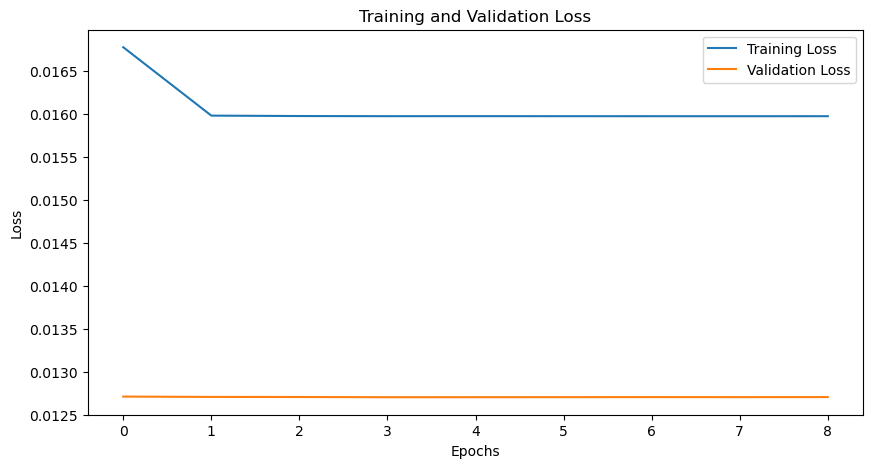

In [26]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 10
patience = 5
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [ ]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [ ]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [ ]:
list(stock_embeddings.items())[:2]

#### Cosine Similarity Matrix

In [ ]:
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

#### Model Features Check

In [ ]:
for batch in train_dataloader:
    print(batch)
    break

In [ ]:
batch["features"].shape

In [ ]:
batch["target"].shape

In [ ]:
len(batch["permno_id"])

In [ ]:
batch["features"][:5]

In [ ]:
model(batch["features"].to(device))

In [ ]:
train_dataset.sequences[-5:]

In [ ]:
np.array(stock_embeddings["10104"]).shape

### Case 1: Model-Simple-1 (128 days, 7 features and 11 targets, simple - less embedbding size and less layers)
Features:  
'log_return'  
'postional encoding'  
"sector_weighted_avg_log_return"  
"sector_simple_avg_log_return"  
"weighted_avg_log_return"  
"simple_avg_log_return"  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Labels:
"log_return"  
"abs_log_return"  
"log_return_7"  
"abs_log_return_7"  
"log_return_14"  
"abs_log_return_14"  
"log_return_28"  
"abs_log_return_28"  
"volatility_7"  
"volatility_14"  
"volatility_28"

#### Create Dataset

In [23]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data["positional_encoding"] = self.data.groupby("permno_id").cumcount()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values
                    # print(X)
                    # permno_id_one_hot_repeated = np.tile(permno_id_one_hot[i], (self.window_size, 1))
                    # print(permno_id_one_hot_repeated.shape)
                    # positional_encoding = np.arange(self.window_size).reshape(-1, 1)
                    # print(positional_encoding.shape)
                    X = np.concatenate(
                        [X, permno_id_one_hot[i : i + self.window_size]], axis=1
                    )  # Concatenate one-hot encoded permno_id
                    X = np.concatenate(
                        [X, group["positional_encoding"].iloc[i : i + self.window_size].values.reshape(-1, 1)], axis=1
                    )
                    # X = np.concatenate([X, permno_id_one_hot_repeated, positional_encoding], axis=1)
                    # print(X.shape)
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }

In [24]:
# %%time
# # Prepare Data

# # First, apply the OneHotEncoder to the entire dataset
# cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoder.fit(cleaned_data[["permno_id"]])

# # Split data
# train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
# validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

# # Create datasets
# train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
# val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [25]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2023-09-30"]
validation_data = cleaned_data[cleaned_data["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

CPU times: user 7min 4s, sys: 2min 6s, total: 9min 11s
Wall time: 9min 11s


#### Build and Train Model

In [26]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

Starting Training...
Epoch 1/5 took 659.05 seconds
Epoch 1/5, Training Loss: 0.09171998954973773, Validation Loss: 0.08243234977632964
Epoch 2/5 took 717.29 seconds
Epoch 2/5, Training Loss: 0.08866600332726357, Validation Loss: 0.083120334142705
Epoch 3/5 took 720.51 seconds
Epoch 3/5, Training Loss: 0.08819506536535197, Validation Loss: 0.08349098105198977
Epoch 4/5 took 702.14 seconds
Epoch 4/5, Training Loss: 0.08798040473158215, Validation Loss: 0.08476964948179365
Early stopping triggered.
Training Complete


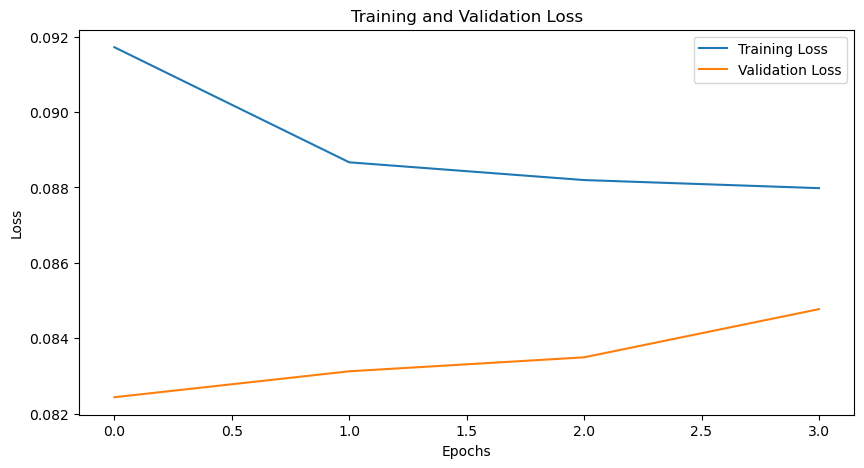

CPU times: user 1d 12h 40min 43s, sys: 38min 38s, total: 1d 13h 19min 21s
Wall time: 46min 39s


In [27]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=128,
    n_heads=8,
    ff_dim=512,
    n_layers=3,
    output_dim=len(train_dataset.target_columns),
    dropout=0.1,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00001)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [ ]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [ ]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [ ]:
list(stock_embeddings.items())[:2]

#### Cosine Similarity Matrix

In [ ]:
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

#### Model Features Check

In [ ]:
for batch in train_dataloader:
    print(batch)
    break

In [ ]:
batch["features"].shape

In [ ]:
batch["target"].shape

In [ ]:
len(batch["permno_id"])

In [ ]:
batch["features"][:5]

In [ ]:
model(batch["features"].to(device))

In [ ]:
train_dataset.sequences[-5:]

In [ ]:
np.array(stock_embeddings["10104"]).shape

### Case 2: Model-Simple-2 (128 days, 7 features and 11 targets, simple - less embedbding size and less layers)
Features:  
'log_return'  
'postional encoding'  
"sector_weighted_avg_log_return"  
"sector_simple_avg_log_return"  
"weighted_avg_log_return"  
"simple_avg_log_return"  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Labels:
"log_return"  
"abs_log_return"  
"log_return_7"  
"abs_log_return_7"  
"log_return_14"  
"abs_log_return_14"  
"log_return_28"  
"abs_log_return_28"  
"volatility_7"  
"volatility_14"  
"volatility_28"

#### Create Dataset

In [23]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data["positional_encoding"] = self.data.groupby("permno_id").cumcount()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values
                    # print(X)
                    # permno_id_one_hot_repeated = np.tile(permno_id_one_hot[i], (self.window_size, 1))
                    # print(permno_id_one_hot_repeated.shape)
                    # positional_encoding = np.arange(self.window_size).reshape(-1, 1)
                    # print(positional_encoding.shape)
                    X = np.concatenate(
                        [X, permno_id_one_hot[i : i + self.window_size]], axis=1
                    )  # Concatenate one-hot encoded permno_id
                    X = np.concatenate(
                        [X, group["positional_encoding"].iloc[i : i + self.window_size].values.reshape(-1, 1)], axis=1
                    )
                    # X = np.concatenate([X, permno_id_one_hot_repeated, positional_encoding], axis=1)
                    # print(X.shape)
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }

In [24]:
# %%time
# # Prepare Data

# # First, apply the OneHotEncoder to the entire dataset
# cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoder.fit(cleaned_data[["permno_id"]])

# # Split data
# train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
# validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

# # Create datasets
# train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
# val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [24]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2023-09-30"]
validation_data = cleaned_data[cleaned_data["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

CPU times: user 7min 6s, sys: 2min 3s, total: 9min 9s
Wall time: 9min 9s


#### Build and Train Model

In [25]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

Starting Training...
Epoch 1/5 took 176.11 seconds
Epoch 1/5, Training Loss: 0.09548261788240728, Validation Loss: 0.08202063690136079
Epoch 2/5 took 192.30 seconds
Epoch 2/5, Training Loss: 0.08957547311283781, Validation Loss: 0.08231601492204026
Epoch 3/5 took 198.16 seconds
Epoch 3/5, Training Loss: 0.08884213348748603, Validation Loss: 0.0824990516249724
Epoch 4/5 took 206.06 seconds
Epoch 4/5, Training Loss: 0.08854140222563849, Validation Loss: 0.08267921756724922
Early stopping triggered.
Training Complete


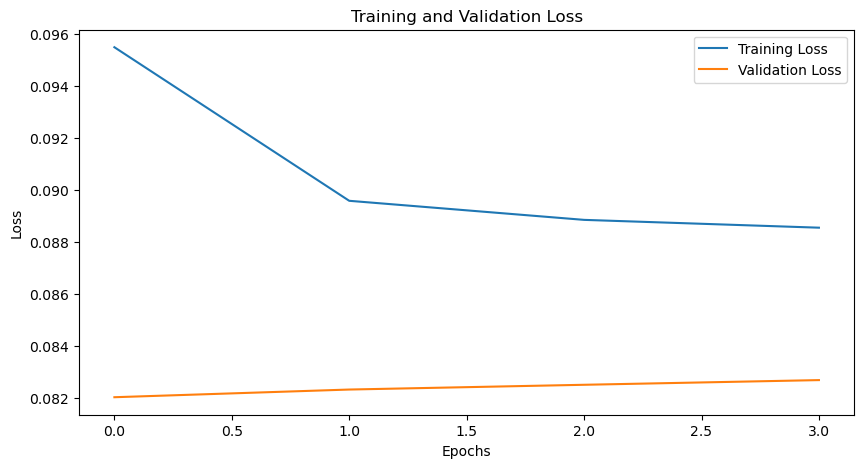

CPU times: user 10h 11min 11s, sys: 7min 8s, total: 10h 18min 19s
Wall time: 12min 52s


In [27]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=64,
    n_heads=4,
    ff_dim=256,
    n_layers=1,
    output_dim=len(train_dataset.target_columns),
    hidden_dims=[128, 64],
    dropout=0.1,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00001)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [28]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [29]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [30]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 1.0617927 , -0.02709917,  0.86792207, -0.31484175, -0.81912076,
          0.8028026 , -0.2765189 ,  1.4565225 ,  0.61450523,  1.0631409 ,
         -0.04765464,  0.4420784 ,  0.07808794, -0.3080687 , -0.61438376,
         -0.46768513,  0.29218423, -0.00696983, -2.2455573 ,  1.5239687 ,
          1.7623643 ,  0.05457364,  2.0052931 ,  1.2241873 , -0.13221222,
          1.2523236 , -0.8419139 ,  0.57833314, -1.1683428 ,  0.35375145,
          0.62363106, -0.19519901, -0.67994744, -2.364642  ,  0.5822225 ,
          0.6329598 , -0.11437857, -1.2658938 ,  0.42877623,  0.48615086,
         -1.0350633 ,  1.2969047 ,  0.18424089,  0.582294  , -1.2053487 ,
          2.198266  , -1.0248904 ,  1.2480083 , -1.0892895 , -1.7120746 ,
         -0.8202889 , -0.31682447, -0.75132275, -1.2320019 , -1.5238146 ,
         -0.957798  ,  0.6482478 , -0.40366572, -0.64492446,  0.88777137,
          0.30129698,  0.23063752, -0.891486  , -0.25202587], dtype=float32)),
 ('10107',
  array([ 1

#### Cosine Similarity Matrix

In [31]:
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[1.0000001 , 0.99999785, 0.9999972 , ..., 0.999998  , 0.9999977 ,
        0.9999981 ],
       [0.99999785, 0.99999994, 0.9999977 , ..., 0.99999774, 0.9999978 ,
        0.999998  ],
       [0.9999972 , 0.9999977 , 0.9999999 , ..., 0.9999982 , 0.99999815,
        0.99999803],
       ...,
       [0.999998  , 0.99999774, 0.9999982 , ..., 1.0000002 , 0.99999744,
        0.99999845],
       [0.9999977 , 0.9999978 , 0.99999815, ..., 0.99999744, 1.        ,
        0.99999815],
       [0.9999981 , 0.999998  , 0.99999803, ..., 0.99999845, 0.99999815,
        1.        ]], dtype=float32)

#### Model Features Check

In [32]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5

In [33]:
batch["features"].shape

torch.Size([32, 128, 560])

In [34]:
batch["target"].shape

torch.Size([32, 11])

In [35]:
len(batch["permno_id"])

32

In [36]:
batch["features"][:5]

tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5.1301e-03, -5

In [37]:
model(batch["features"].to(device))

(tensor([[ 2.5005e-03,  9.6344e-03,  3.3397e-02,  1.2389e-01,  8.0370e-03,
           4.3462e-02, -3.1803e-03,  1.5908e-02,  2.0169e-01,  2.2342e-01,
           2.2822e-01],
         [ 2.4887e-03,  9.6734e-03,  3.3588e-02,  1.2466e-01,  8.2112e-03,
           4.3611e-02, -3.0543e-03,  1.6057e-02,  2.0286e-01,  2.2447e-01,
           2.2920e-01],
         [ 2.4768e-03,  9.7118e-03,  3.3775e-02,  1.2544e-01,  8.3838e-03,
           4.3758e-02, -2.9290e-03,  1.6205e-02,  2.0402e-01,  2.2551e-01,
           2.3017e-01],
         [ 2.4674e-03,  9.7488e-03,  3.3974e-02,  1.2622e-01,  8.5544e-03,
           4.3911e-02, -2.8012e-03,  1.6361e-02,  2.0523e-01,  2.2659e-01,
           2.3115e-01],
         [ 2.4554e-03,  9.7860e-03,  3.4148e-02,  1.2695e-01,  8.7251e-03,
           4.4050e-02, -2.6858e-03,  1.6499e-02,  2.0633e-01,  2.2757e-01,
           2.3207e-01],
         [ 2.4412e-03,  9.8239e-03,  3.4304e-02,  1.2763e-01,  8.8820e-03,
           4.4179e-02, -2.5721e-03,  1.6625e-02,  2.073

In [38]:
train_dataset.sequences[-5:]

[(array([[-3.30853331e-02, -1.46880000e-02, -1.88230000e-02, ...,
           0.00000000e+00,  1.00000000e+00,  1.31300000e+03],
         [ 5.58238943e-03,  8.88100000e-03,  3.76000000e-03, ...,
           0.00000000e+00,  1.00000000e+00,  1.31400000e+03],
         [-9.46061079e-03,  5.69000000e-04,  2.37000000e-04, ...,
           0.00000000e+00,  1.00000000e+00,  1.31500000e+03],
         ...,
         [-1.47806983e-02, -1.52550000e-02, -8.46000000e-03, ...,
           0.00000000e+00,  1.00000000e+00,  1.43800000e+03],
         [-2.65893853e-02, -1.74260000e-02, -1.82480000e-02, ...,
           0.00000000e+00,  1.00000000e+00,  1.43900000e+03],
         [-4.32363651e-02, -3.28000000e-04,  2.98000000e-04, ...,
           0.00000000e+00,  1.00000000e+00,  1.44000000e+03]]),
  array([ 0.00857909,  0.00857909,  0.33228679,  0.33228679,  0.02155068,
          0.02155068, -0.03861463,  0.03861463,  0.43503314,  0.35140562,
          0.51255168]),
  '93436'),
 (array([[ 5.58238943e-03,  8.88

In [39]:
np.array(stock_embeddings["10104"]).shape

(64,)

### Case 3: Model-Complex (128 days, 7 features and 11 targets, simple - less embedbding size and less layers)
Features:  
'log_return'  
'postional encoding'  
"sector_weighted_avg_log_return"  
"sector_simple_avg_log_return"  
"weighted_avg_log_return"  
"simple_avg_log_return"  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Labels:
"log_return"  
"abs_log_return"  
"log_return_7"  
"abs_log_return_7"  
"log_return_14"  
"abs_log_return_14"  
"log_return_28"  
"abs_log_return_28"  
"volatility_7"  
"volatility_14"  
"volatility_28"

#### Create Dataset

In [23]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data["positional_encoding"] = self.data.groupby("permno_id").cumcount()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values
                    # print(X)
                    # permno_id_one_hot_repeated = np.tile(permno_id_one_hot[i], (self.window_size, 1))
                    # print(permno_id_one_hot_repeated.shape)
                    # positional_encoding = np.arange(self.window_size).reshape(-1, 1)
                    # print(positional_encoding.shape)
                    X = np.concatenate(
                        [X, permno_id_one_hot[i : i + self.window_size]], axis=1
                    )  # Concatenate one-hot encoded permno_id
                    X = np.concatenate(
                        [X, group["positional_encoding"].iloc[i : i + self.window_size].values.reshape(-1, 1)], axis=1
                    )
                    # X = np.concatenate([X, permno_id_one_hot_repeated, positional_encoding], axis=1)
                    # print(X.shape)
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }

In [24]:
# %%time
# # Prepare Data

# # First, apply the OneHotEncoder to the entire dataset
# cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoder.fit(cleaned_data[["permno_id"]])

# # Split data
# train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
# validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

# # Create datasets
# train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
# val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [25]:
%%time
# Prepare Data

# Ensure the data is sorted by date for each permno_id
cleaned_data = cleaned_data.sort_values(by=["permno_id", "date"])

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2023-09-30"]
validation_data = cleaned_data[cleaned_data["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

CPU times: user 7min 4s, sys: 2min 5s, total: 9min 9s
Wall time: 9min 9s


#### Build and Train Model

In [26]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding

In [ ]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=1024,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    hidden_dims=[256, 128],
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Starting Training...
Epoch 1/5 took 10786.87 seconds
Epoch 1/5, Training Loss: 0.09050416299881606, Validation Loss: 0.08882468211508933
Epoch 2/5 took 11287.22 seconds
Epoch 2/5, Training Loss: 0.08813030013946346, Validation Loss: 0.08532720567899293


#### Stock Embedding

In [ ]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [ ]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [30]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 1.0617927 , -0.02709917,  0.86792207, -0.31484175, -0.81912076,
          0.8028026 , -0.2765189 ,  1.4565225 ,  0.61450523,  1.0631409 ,
         -0.04765464,  0.4420784 ,  0.07808794, -0.3080687 , -0.61438376,
         -0.46768513,  0.29218423, -0.00696983, -2.2455573 ,  1.5239687 ,
          1.7623643 ,  0.05457364,  2.0052931 ,  1.2241873 , -0.13221222,
          1.2523236 , -0.8419139 ,  0.57833314, -1.1683428 ,  0.35375145,
          0.62363106, -0.19519901, -0.67994744, -2.364642  ,  0.5822225 ,
          0.6329598 , -0.11437857, -1.2658938 ,  0.42877623,  0.48615086,
         -1.0350633 ,  1.2969047 ,  0.18424089,  0.582294  , -1.2053487 ,
          2.198266  , -1.0248904 ,  1.2480083 , -1.0892895 , -1.7120746 ,
         -0.8202889 , -0.31682447, -0.75132275, -1.2320019 , -1.5238146 ,
         -0.957798  ,  0.6482478 , -0.40366572, -0.64492446,  0.88777137,
          0.30129698,  0.23063752, -0.891486  , -0.25202587], dtype=float32)),
 ('10107',
  array([ 1

#### Cosine Similarity Matrix

In [31]:
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[1.0000001 , 0.99999785, 0.9999972 , ..., 0.999998  , 0.9999977 ,
        0.9999981 ],
       [0.99999785, 0.99999994, 0.9999977 , ..., 0.99999774, 0.9999978 ,
        0.999998  ],
       [0.9999972 , 0.9999977 , 0.9999999 , ..., 0.9999982 , 0.99999815,
        0.99999803],
       ...,
       [0.999998  , 0.99999774, 0.9999982 , ..., 1.0000002 , 0.99999744,
        0.99999845],
       [0.9999977 , 0.9999978 , 0.99999815, ..., 0.99999744, 1.        ,
        0.99999815],
       [0.9999981 , 0.999998  , 0.99999803, ..., 0.99999845, 0.99999815,
        1.        ]], dtype=float32)

#### Model Features Check

In [32]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5

In [33]:
batch["features"].shape

torch.Size([32, 128, 560])

In [34]:
batch["target"].shape

torch.Size([32, 11])

In [35]:
len(batch["permno_id"])

32

In [36]:
batch["features"][:5]

tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.9999e-02,  8.8280e-03,  8.2140e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2500e+02],
         [-5.1301e-03, -5.7360e-03, -1.3760e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.2600e+02],
         [ 1.5311e-02,  1.1983e-02,  1.2778e-02,  ...,  0.0000e+00,
           0.0000e+00,  1.2700e+02]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  3.0000e+00],
         ...,
         [-5.1301e-03, -5

In [37]:
model(batch["features"].to(device))

(tensor([[ 2.5005e-03,  9.6344e-03,  3.3397e-02,  1.2389e-01,  8.0370e-03,
           4.3462e-02, -3.1803e-03,  1.5908e-02,  2.0169e-01,  2.2342e-01,
           2.2822e-01],
         [ 2.4887e-03,  9.6734e-03,  3.3588e-02,  1.2466e-01,  8.2112e-03,
           4.3611e-02, -3.0543e-03,  1.6057e-02,  2.0286e-01,  2.2447e-01,
           2.2920e-01],
         [ 2.4768e-03,  9.7118e-03,  3.3775e-02,  1.2544e-01,  8.3838e-03,
           4.3758e-02, -2.9290e-03,  1.6205e-02,  2.0402e-01,  2.2551e-01,
           2.3017e-01],
         [ 2.4674e-03,  9.7488e-03,  3.3974e-02,  1.2622e-01,  8.5544e-03,
           4.3911e-02, -2.8012e-03,  1.6361e-02,  2.0523e-01,  2.2659e-01,
           2.3115e-01],
         [ 2.4554e-03,  9.7860e-03,  3.4148e-02,  1.2695e-01,  8.7251e-03,
           4.4050e-02, -2.6858e-03,  1.6499e-02,  2.0633e-01,  2.2757e-01,
           2.3207e-01],
         [ 2.4412e-03,  9.8239e-03,  3.4304e-02,  1.2763e-01,  8.8820e-03,
           4.4179e-02, -2.5721e-03,  1.6625e-02,  2.073

In [38]:
train_dataset.sequences[-5:]

[(array([[-3.30853331e-02, -1.46880000e-02, -1.88230000e-02, ...,
           0.00000000e+00,  1.00000000e+00,  1.31300000e+03],
         [ 5.58238943e-03,  8.88100000e-03,  3.76000000e-03, ...,
           0.00000000e+00,  1.00000000e+00,  1.31400000e+03],
         [-9.46061079e-03,  5.69000000e-04,  2.37000000e-04, ...,
           0.00000000e+00,  1.00000000e+00,  1.31500000e+03],
         ...,
         [-1.47806983e-02, -1.52550000e-02, -8.46000000e-03, ...,
           0.00000000e+00,  1.00000000e+00,  1.43800000e+03],
         [-2.65893853e-02, -1.74260000e-02, -1.82480000e-02, ...,
           0.00000000e+00,  1.00000000e+00,  1.43900000e+03],
         [-4.32363651e-02, -3.28000000e-04,  2.98000000e-04, ...,
           0.00000000e+00,  1.00000000e+00,  1.44000000e+03]]),
  array([ 0.00857909,  0.00857909,  0.33228679,  0.33228679,  0.02155068,
          0.02155068, -0.03861463,  0.03861463,  0.43503314,  0.35140562,
          0.51255168]),
  '93436'),
 (array([[ 5.58238943e-03,  8.88

In [39]:
np.array(stock_embeddings["10104"]).shape

(64,)

### Case 3: Model (7 days, 7 features and 11 targets)
Features:  
'log_return'  
'postional encoding'  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Label:
'log_return' 

In [23]:
cleaned_data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
0,2018-01-02,10104,-0.013843,0.013843,0.000000,0.000000,0.000000,0.000000,0.309424,0.309424,0.131071,0.131071,0.011619,0.011619,0.136136,0.109282,0.276310
1,2018-01-03,10104,0.022897,0.022897,0.006404,0.004872,0.005904,0.007983,0.234088,0.234088,0.107382,0.107382,0.006475,0.006475,0.091648,0.081082,0.268724
2,2018-01-04,10104,0.009803,0.009803,0.004048,0.000960,0.004021,0.000852,0.183199,0.183199,0.097613,0.097613,0.009651,0.009651,0.089939,0.079524,0.273385
3,2018-01-05,10104,0.006001,0.006001,0.009581,0.006722,0.006193,0.002919,0.230474,0.230474,0.120486,0.120486,0.015437,0.015437,0.105015,0.107098,0.281463
4,2018-01-08,10104,0.010467,0.010467,0.002142,0.005354,0.001829,0.005828,0.161223,0.161223,0.083731,0.083731,0.012476,0.012476,0.105560,0.139328,0.280139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794366,2023-11-13,93436,0.041342,0.041342,0.000410,0.000916,-0.000400,-0.000701,0.266036,0.266036,0.068729,0.068729,0.039733,0.039733,0.530805,0.426937,0.378195
794367,2023-11-14,93436,0.059438,0.059438,0.025191,0.037168,0.022485,0.018177,-0.041740,0.041740,0.007099,0.007099,0.025312,0.025312,0.383085,0.347634,0.339596
794368,2023-11-15,93436,0.022614,0.022614,0.004464,0.003711,0.001887,0.006906,-0.135146,0.135146,-0.018335,0.018335,0.024006,0.024006,0.348145,0.332918,0.337636
794369,2023-11-16,93436,-0.038835,0.038835,-0.000869,-0.004937,-0.001334,0.004114,0.324775,0.324775,0.050085,0.050085,0.026224,0.026224,0.355413,0.288883,0.330446


#### Create Dataset

In [26]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=7, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Assign positional encoding
        self.data["positional_encoding"] = self.data.groupby("permno_id").cumcount()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values
                    # print(X)
                    # permno_id_one_hot_repeated = np.tile(permno_id_one_hot[i], (self.window_size, 1))
                    # print(permno_id_one_hot_repeated.shape)
                    # positional_encoding = np.arange(self.window_size).reshape(-1, 1)
                    # print(positional_encoding.shape)
                    X = np.concatenate(
                        [X, permno_id_one_hot[i : i + self.window_size]], axis=1
                    )  # Concatenate one-hot encoded permno_id
                    X = np.concatenate(
                        [X, group["positional_encoding"].iloc[i : i + self.window_size].values.reshape(-1, 1)], axis=1
                    )
                    # X = np.concatenate([X, permno_id_one_hot_repeated, positional_encoding], axis=1)
                    # print(X.shape)
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


# Prepare Data

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

#### Build and Train Model

Starting Training...
Epoch 1/10, Training Loss: 0.09156142956979248, Validation Loss: 0.08231207029314012
Epoch 2/10, Training Loss: 0.08915924277880051, Validation Loss: 0.07353917578812158
Epoch 3/10, Training Loss: 0.08909141032479667, Validation Loss: 0.073491502792435
Epoch 4/10, Training Loss: 0.08902445788692094, Validation Loss: 0.07509884722644261
Epoch 5/10, Training Loss: 0.08903481386801218, Validation Loss: 0.07299888564787708
Epoch 6/10, Training Loss: 0.08895725816991294, Validation Loss: 0.07657859663417423
Epoch 7/10, Training Loss: 0.08898307561385216, Validation Loss: 0.07334241026137596
Epoch 8/10, Training Loss: 0.08893751073641985, Validation Loss: 0.07232822793534084
Epoch 9/10, Training Loss: 0.08894478459983492, Validation Loss: 0.07350584668814393
Epoch 10/10, Training Loss: 0.08894648703423268, Validation Loss: 0.07246848407781194
Training Complete


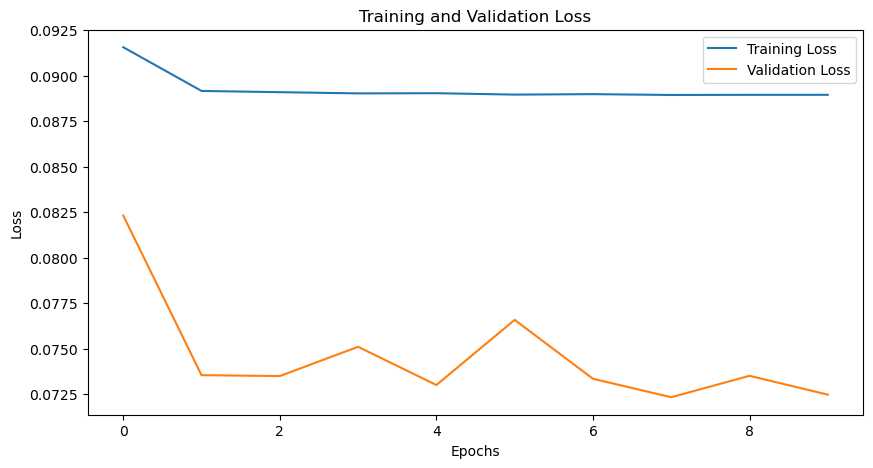

In [27]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        x = self.transformer(x)
        embedding = x[-1, :, :]  # Get the last output token
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x, embedding


# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = len(train_dataset.input_columns) + len(one_hot_encoder.categories_[0]) + 1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 10
patience = 5
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [28]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [29]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [30]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-1.70700978e-02, -6.43775538e-02, -8.40254128e-03,  2.50011440e-02,
         -3.12255276e-03, -9.71500110e-03, -7.71201998e-02, -1.02632167e-02,
          2.17697937e-02,  1.44426050e-02, -1.50586013e-02,  1.28879528e-02,
          1.30312378e-02,  7.03353807e-02, -9.29138344e-03,  1.31744742e-01,
         -2.14138366e-02,  7.05869356e-03,  2.08555069e-02, -2.54420321e-02,
         -2.87152757e-03,  3.54975485e-03,  8.84628389e-03,  3.74198318e-01,
          4.89792600e-03,  2.15039067e-02,  5.88734411e-02,  3.01029924e-02,
          3.55822109e-02,  8.58693942e-02, -9.30715725e-03,  5.11734039e-02,
          5.95531706e-03,  6.09969981e-02, -2.36076675e-02,  3.09775800e-01,
          6.02180138e-02, -2.45847702e+00,  4.69063595e-02,  4.40035760e-02,
         -1.63575616e-02, -2.05594048e-01,  2.85502195e-01, -6.24550022e-02,
          2.61247611e+00, -5.94890527e-02,  2.10909173e-02,  6.36959216e-03,
          6.82456344e-02,  9.62147936e-02, -3.74289602e-03, -1.43

#### Cosine Similarity Matrix

In [31]:
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[1.0000002, 1.0000002, 1.0000002, ..., 1.0000002, 1.0000002,
        1.0000002],
       [1.0000002, 1.0000002, 1.0000002, ..., 1.0000002, 1.0000002,
        1.0000002],
       [1.0000002, 1.0000002, 1.0000002, ..., 1.0000002, 1.0000002,
        1.0000002],
       ...,
       [1.0000002, 1.0000002, 1.0000002, ..., 1.0000002, 1.0000002,
        1.0000002],
       [1.0000002, 1.0000002, 1.0000002, ..., 1.0000002, 1.0000002,
        1.0000002],
       [1.0000002, 1.0000002, 1.0000002, ..., 1.0000002, 1.0000002,
        1.0000002]], dtype=float32)

#### Model Features Check

In [31]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.0467e-02,  2.1420e-03,  5.3540e-03,  ...,  0.0000e+00,
           0.0000e+00,  4.0000e+00],
         [ 5.4969e-03, -2.6340e-03, -2.7040e-03,  ...,  0.0000e+00,
           0.0000e+00,  5.0000e+00],
         [-5.3141e-03, -2.4190e-03, -1.9280e-03,  ...,  0.0000e+00,
           0.0000e+00,  6.0000e+00]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 5

In [32]:
batch["features"].shape

torch.Size([32, 7, 560])

In [33]:
batch["target"].shape

torch.Size([32, 11])

In [34]:
len(batch["permno_id"])

32

In [43]:
batch["features"][:5]

tensor([[[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 1.0467e-02,  2.1420e-03,  5.3540e-03,  ...,  0.0000e+00,
           0.0000e+00,  4.0000e+00],
         [ 5.4969e-03, -2.6340e-03, -2.7040e-03,  ...,  0.0000e+00,
           0.0000e+00,  5.0000e+00],
         [-5.3141e-03, -2.4190e-03, -1.9280e-03,  ...,  0.0000e+00,
           0.0000e+00,  6.0000e+00]],

        [[ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  0.0000e+00,
           0.0000e+00,  2.0000e+00],
         ...,
         [ 5.4969e-03, -2

In [36]:
model(batch["features"].to(device))

(tensor([[-0.0020,  0.0011,  0.0152,  0.0886,  0.0010,  0.0330,  0.0021,  0.0260,
           0.1799,  0.1915,  0.1888],
         [-0.0020,  0.0010,  0.0151,  0.0885,  0.0010,  0.0329,  0.0020,  0.0259,
           0.1798,  0.1914,  0.1887],
         [-0.0020,  0.0010,  0.0152,  0.0886,  0.0009,  0.0330,  0.0021,  0.0259,
           0.1798,  0.1915,  0.1887],
         [-0.0019,  0.0011,  0.0151,  0.0887,  0.0009,  0.0331,  0.0021,  0.0260,
           0.1799,  0.1915,  0.1888],
         [-0.0020,  0.0010,  0.0152,  0.0886,  0.0008,  0.0330,  0.0021,  0.0260,
           0.1798,  0.1915,  0.1888],
         [-0.0019,  0.0011,  0.0151,  0.0887,  0.0009,  0.0330,  0.0021,  0.0260,
           0.1799,  0.1915,  0.1888],
         [-0.0019,  0.0011,  0.0151,  0.0886,  0.0009,  0.0330,  0.0021,  0.0260,
           0.1799,  0.1915,  0.1887],
         [-0.0020,  0.0010,  0.0151,  0.0885,  0.0009,  0.0330,  0.0020,  0.0260,
           0.1798,  0.1914,  0.1886],
         [-0.0019,  0.0010,  0.0151,  0.

In [37]:
train_dataset.sequences[-5:]

[(array([[-1.96385808e-02, -2.22870000e-02, -3.19420000e-02, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 7.90169919e-03,  1.29550000e-02,  7.79200000e-03, ...,
           0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
         [ 1.24027667e-02,  2.23980000e-02,  3.01470000e-02, ...,
           0.00000000e+00,  0.00000000e+00,  2.00000000e+00],
         ...,
         [-1.91282829e-03, -1.32400000e-02, -3.54850000e-02, ...,
           0.00000000e+00,  0.00000000e+00,  4.00000000e+00],
         [ 1.45081680e-01,  1.42930000e-02, -3.86700000e-03, ...,
           0.00000000e+00,  0.00000000e+00,  5.00000000e+00],
         [-1.70993644e-02, -7.50000000e-03, -6.12600000e-03, ...,
           0.00000000e+00,  0.00000000e+00,  6.00000000e+00]]),
  array([-0.00996145,  0.00996145, -0.42433243,  0.42433243, -0.13991876,
          0.13991876, -0.06378652,  0.06378652,  0.55133603,  0.40099837,
          0.31851795]),
  '10104'),
 (array([[ 7.90169919e-03,  1.29

In [38]:
np.array(stock_embeddings["10104"]).shape

(256,)

### Case 1-old: Model-Baseline (3 features and 1 target)
Features:  
'log_return'  
'postional encoding'  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Label:
'log_return' 

#### Create Dataset

In [24]:
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            # "sector_weighted_avg_log_return",
            # "sector_simple_avg_log_return",
            # "weighted_avg_log_return",
            # "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            # "abs_log_return",
            # "log_return_7",
            # "abs_log_return_7",
            # "log_return_14",
            # "abs_log_return_14",
            # "log_return_28",
            # "abs_log_return_28",
            # "volatility_7",
            # "volatility_14",
            # "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values.flatten()
                    X = np.concatenate([X, permno_id_one_hot[i]])  # Concatenate one-hot encoded permno_id
                    X = np.append(X, j)
                    j += 1
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }

In [99]:
# Prepare Data

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"][:20000]
validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"][:20000]

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

#### Build and Train Model

In [100]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Adding hidden layers and dropout
        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add a dimension for sequence length (seq_len=1)
        x = self.transformer(x)
        embedding = x[:, -1, :]
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x.squeeze(-1), embedding

Starting Training...
Epoch 1/10, Training Loss: 0.02464975892855406, Validation Loss: 0.016168133197528013
Epoch 2/10, Training Loss: 0.015802889032359612, Validation Loss: 0.016141946789509844
Epoch 3/10, Training Loss: 0.014901299695057971, Validation Loss: 0.015702074632610915
Epoch 4/10, Training Loss: 0.014400017524683176, Validation Loss: 0.014288059219647691
Epoch 5/10, Training Loss: 0.014057001866453747, Validation Loss: 0.01351682940884581
Epoch 6/10, Training Loss: 0.01378762764986638, Validation Loss: 0.012929118716351266
Epoch 7/10, Training Loss: 0.013661864966060465, Validation Loss: 0.013018904355758766
Epoch 8/10, Training Loss: 0.013564022219049305, Validation Loss: 0.013016177634796443
Epoch 9/10, Training Loss: 0.01350862458281393, Validation Loss: 0.01295208973142336
Epoch 10/10, Training Loss: 0.013440647670377172, Validation Loss: 0.012894980388008199
Training Complete


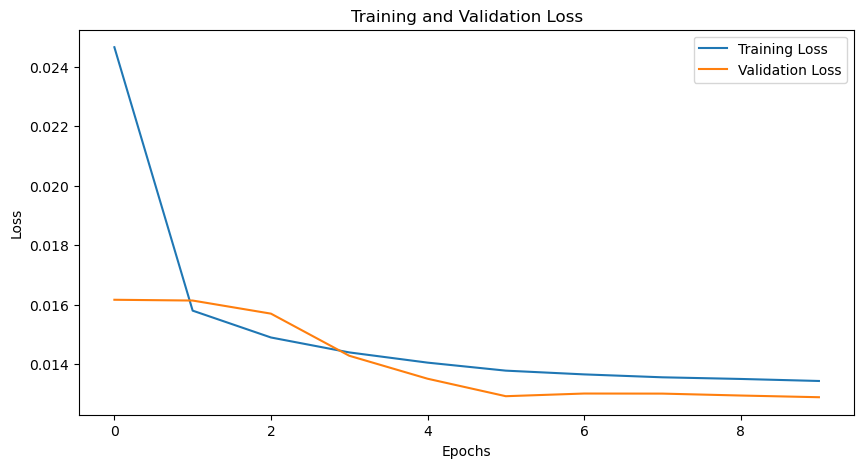

In [101]:
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = (128 * len(train_dataset.input_columns) + 1) + len(one_hot_encoder.categories_[0])
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 10
patience = 5
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [106]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [107]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [108]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ -4.3767214 ,  14.636883  , -10.055592  , -17.184486  ,
          12.779612  ,  18.795858  ,  -9.638161  , -16.849627  ,
          12.37308   ,  23.82522   ,  18.170925  ,  -3.7599223 ,
         -10.9022455 ,  -4.0993266 ,   7.4138145 ,  -5.139669  ,
          20.701363  ,  18.141117  ,  -9.857887  ,  -8.52524   ,
          24.640705  , -25.50016   ,  -8.3154545 ,  10.254896  ,
          21.660477  ,  12.833984  ,   3.3258986 ,  11.894244  ,
         -11.285699  , -23.227407  ,  12.576371  ,  -4.3835297 ,
          -5.974343  ,  -0.5579752 ,   7.2592387 ,  14.098306  ,
          -5.506613  ,  11.127786  , -14.507936  ,  -5.0083437 ,
          -1.4023945 , -19.955734  ,  25.78464   , -22.400215  ,
          24.69616   ,  14.438254  ,  -3.11553   ,  12.881308  ,
         -23.141258  , -21.589685  ,  -0.2381519 ,  10.360712  ,
          21.921164  , -22.078854  ,  -9.018872  ,  -8.801734  ,
          13.660214  ,  14.30209   ,  17.573559  , -22.314953  ,
           0.5

#### Cosine Similarity Matrix

In [109]:
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[0.9999998 , 0.9999981 , 0.9999983 , 0.99999833, 0.99999815,
        0.9999984 , 0.9999975 , 0.9999981 , 0.9999983 , 0.99999803,
        0.99999046, 0.9999985 , 0.9999979 , 0.9999978 , 0.9999981 ,
        0.9999979 , 0.9999968 ],
       [0.9999981 , 1.0000001 , 0.9999978 , 0.99999815, 0.99999815,
        0.9999977 , 0.9999975 , 0.9999977 , 0.9999975 , 0.99999845,
        0.9999902 , 0.99999803, 0.99999744, 0.99999785, 0.9999981 ,
        0.9999977 , 0.9999967 ],
       [0.9999983 , 0.9999978 , 0.9999999 , 0.9999978 , 0.99999785,
        0.9999978 , 0.9999975 , 0.99999845, 0.9999983 , 0.99999815,
        0.9999906 , 0.9999976 , 0.99999815, 0.99999785, 0.9999978 ,
        0.9999977 , 0.99999654],
       [0.99999833, 0.99999815, 0.9999978 , 0.9999999 , 0.999998  ,
        0.99999774, 0.9999977 , 0.99999785, 0.99999803, 0.9999981 ,
        0.9999901 , 0.9999982 , 0.99999803, 0.999998  , 0.9999977 ,
        0.99999744, 0.99999696],
       [0.99999815, 0.99999815, 0.99999785, 0.999998

#### Model Features Check

In [47]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[-1.3843e-02,  2.2897e-02,  9.8028e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2800e+02],
        [ 2.2897e-02,  9.8028e-03,  6.0010e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2900e+02],
        [ 9.8028e-03,  6.0010e-03,  1.0467e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.3000e+02],
        ...,
        [ 7.0362e-03,  1.9605e-02,  2.3780e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.5700e+02],
        [ 1.9605e-02,  2.3780e-02,  1.3810e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.5800e+02],
        [ 2.3780e-02,  1.3810e-03, -1.6302e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.5900e+02]]), 'target': tensor([[ 0.0129],
        [ 0.0157],
        [ 0.0055],
        [ 0.0137],
        [ 0.0106],
        [ 0.0099],
        [ 0.0004],
        [ 0.0090],
        [-0.0053],
        [-0.0041],
        [ 0.0017],
        [ 0.0031],
        [ 0.0000],
        [ 0.0057],
        [-0.0016],
        [-0.0049],
        [-0.0187],
        [-0.0010],
  

In [34]:
batch["features"].shape

torch.Size([32, 683])

In [35]:
batch["target"].shape

torch.Size([32, 1])

In [36]:
len(batch["permno_id"])

32

In [48]:
batch["features"][:5]

tensor([[-1.3843e-02,  2.2897e-02,  9.8028e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2800e+02],
        [ 2.2897e-02,  9.8028e-03,  6.0010e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2900e+02],
        [ 9.8028e-03,  6.0010e-03,  1.0467e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.3000e+02],
        [ 6.0010e-03,  1.0467e-02,  5.4969e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.3100e+02],
        [ 1.0467e-02,  5.4969e-03, -5.3141e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.3200e+02]])

In [38]:
model(batch["features"].to(device))

(tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010], device='cuda:0',
        grad_fn=<SqueezeBackward1>),
 tensor([[-0.3373, -0.4735,  1.6776,  ...,  2.7894, -0.0613,  0.3435],
         [-0.3373, -0.4735,  1.6775,  ...,  2.7894, -0.0613,  0.3435],
         [-0.3373, -0.4735,  1.6775,  ...,  2.7894, -0.0613,  0.3435],
         ...,
         [-0.3373, -0.4735,  1.6775,  ...,  2.7894, -0.0613,  0.3435],
         [-0.3373, -0.4735,  1.6775,  ...,  2.7894, -0.0613,  0.3435],
         [-0.3373, -0.4735,  1.6775,  ...,  2.7894, -0.0613,  0.3435]],
        device='cuda:0', grad_fn=<SliceBackward0>))

In [41]:
train_dataset.sequences[-5:]

[(array([-4.31529752e-03,  4.42551345e-02, -3.20713737e-03, -5.13396112e-02,
         -1.80998179e-02, -1.77353456e-02,  1.23523941e-02,  2.52154027e-02,
         -5.73742761e-03,  5.38051869e-02,  2.51169128e-02, -6.77222505e-02,
         -5.44881788e-03,  1.68895649e-02,  5.35762228e-03,  7.33006928e-03,
          1.99700466e-03,  2.05053215e-02,  7.99098685e-03,  9.33127317e-02,
          1.97305225e-03, -1.40938534e-02, -3.63154974e-02,  5.98290113e-02,
          2.18828151e-02,  5.62385464e-02,  4.25909288e-04,  1.10724733e-02,
          2.24031645e-02,  4.01492937e-03, -6.86033045e-02,  7.78859003e-03,
         -2.47159379e-02,  3.81682364e-02, -2.65996548e-02,  4.56901259e-02,
          3.04942869e-02, -8.95194940e-03, -8.40724203e-03, -3.71288423e-03,
         -2.06946650e-02, -2.30271003e-02,  2.23073310e-02,  2.16764895e-03,
         -3.46198576e-03, -2.73228937e-02, -1.14159143e-02, -2.53157567e-02,
         -7.55446324e-03,  5.60824436e-03, -2.53957597e-02,  1.54608625e-02,

In [40]:
np.array(stock_embeddings["10104"]).shape

(256,)

### Case 2-old: Model (7 features and 11 targets)
Features:  
'log_return'  
'postional encoding'  
"sector_weighted_avg_log_return"  
"sector_simple_avg_log_return"  
"weighted_avg_log_return"  
"simple_avg_log_return"  
'permno_one_hot' - one-hot-encoder for permno_id - Categorical Feature  

Labels:
"log_return"  
"abs_log_return"  
"log_return_7"  
"abs_log_return_7"  
"log_return_14"  
"abs_log_return_14"  
"log_return_28"  
"abs_log_return_28"  
"volatility_7"  
"volatility_14"  
"volatility_28"  

#### Create Dataset

In [49]:
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128, one_hot_encoder=None):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return",
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        self.one_hot_encoder = one_hot_encoder
        if self.one_hot_encoder is None:
            self.one_hot_encoder = OneHotEncoder(sparse_output=False)
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]])
        else:
            self.data["permno_id"] = self.data["permno_id"].astype(str)
            self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]])

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            permno_id_one_hot = self.one_hot_encoder.transform(group[["permno_id"]])
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values.flatten()
                    X = np.concatenate([X, permno_id_one_hot[i]])  # Concatenate one-hot encoded permno_id
                    X = np.append(X, j)
                    j += 1
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }

In [50]:
# Prepare Data

# First, apply the OneHotEncoder to the entire dataset
cleaned_data["permno_id"] = cleaned_data["permno_id"].astype(str)
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(cleaned_data[["permno_id"]])

# Split data
train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

# Create datasets
train_dataset = FinancialDataset(train_data, one_hot_encoder=one_hot_encoder)
val_dataset = FinancialDataset(validation_data, one_hot_encoder=one_hot_encoder)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

#### Build and Train Model

In [51]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Adding hidden layers and dropout
        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = self.transformer(x)
        embedding = x[:, -1, :]
        x = self.hidden_layers(embedding)
        x = self.fc(x)
        return x.squeeze(-1), embedding

Starting Training...
Epoch 1/10, Training Loss: 0.09393594993297916, Validation Loss: 0.07873438894890245
Epoch 2/10, Training Loss: 0.09117041960287199, Validation Loss: 0.07355478685998026
Epoch 3/10, Training Loss: 0.09114890185280168, Validation Loss: 0.0747607945051089
Epoch 4/10, Training Loss: 0.0910783144283853, Validation Loss: 0.07420810096631177
Epoch 5/10, Training Loss: 0.09105398065409864, Validation Loss: 0.07397140378747052
Epoch 6/10, Training Loss: 0.09105769559242263, Validation Loss: 0.07337269635943011
Epoch 7/10, Training Loss: 0.09099031555486183, Validation Loss: 0.07486673203627847
Epoch 8/10, Training Loss: 0.09095634965778672, Validation Loss: 0.07455270071151213
Epoch 9/10, Training Loss: 0.09098481258619906, Validation Loss: 0.07395662671689975
Epoch 10/10, Training Loss: 0.09096872223133336, Validation Loss: 0.07394769659679928
Training Complete


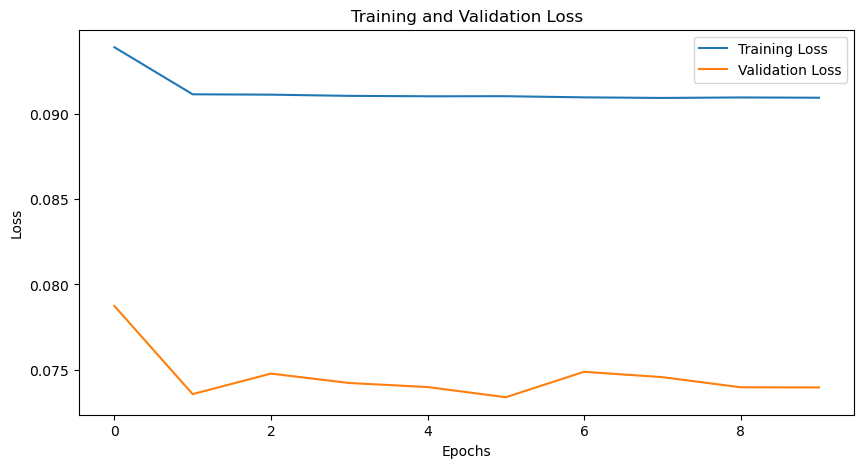

In [52]:
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = (128 * len(train_dataset.input_columns) + 1) + len(one_hot_encoder.categories_[0])
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 10
patience = 5
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Stock Embedding

In [53]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [54]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [55]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-3.21087278e-02,  2.74276696e-02,  3.61454524e-02, -3.78264710e-02,
          6.79169074e-02,  8.48998785e-01, -1.00488842e-01,  6.98425546e-02,
          2.83112600e-02,  3.83709073e+00, -3.88179016e+00,  3.66215849e+00,
         -1.07933171e-01,  4.12893035e-02,  2.42160350e-01, -1.63294300e-01,
         -1.16950311e-01,  6.28130138e-02,  2.52505004e-01,  1.36956596e-03,
          1.12524144e-01, -2.17819229e-01, -1.35442197e-01, -2.76513624e+00,
          3.51662338e-02, -2.25921422e-01,  1.03505496e-02, -1.18311441e+00,
         -7.13679492e-01, -9.65118781e-02,  6.36596158e-02,  3.31135958e-01,
         -1.30289626e+00,  1.06567368e-01,  4.94723409e-01,  3.32910490e+00,
         -2.12388597e-02,  4.63916212e-02, -8.97697434e-02, -3.00726108e-02,
         -2.99734492e-02, -4.49500650e-01, -4.50171717e-02,  1.75523028e-01,
         -7.69348219e-02, -1.08703144e-01, -2.57064519e-03,  7.38984942e-02,
         -9.46656466e-02,  1.07675530e-01, -7.48924613e-02,  1.87

#### Cosine Similarity Matrix

In [56]:
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[0.9999997 , 0.9999997 , 0.99999964, ..., 0.9999997 , 0.9999997 ,
        0.9999997 ],
       [0.9999997 , 0.9999997 , 0.99999964, ..., 0.9999997 , 0.9999997 ,
        0.9999997 ],
       [0.99999964, 0.99999964, 0.99999964, ..., 0.99999964, 0.99999964,
        0.99999964],
       ...,
       [0.9999997 , 0.9999997 , 0.99999964, ..., 0.9999997 , 0.9999997 ,
        0.9999997 ],
       [0.9999997 , 0.9999997 , 0.99999964, ..., 0.9999997 , 0.9999997 ,
        0.9999997 ],
       [0.9999997 , 0.9999997 , 0.99999964, ..., 0.9999997 , 0.9999997 ,
        0.9999997 ]], dtype=float32)

#### Model Features Check

In [58]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  1.2800e+02],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.2900e+02],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  0.0000e+00,
          0.0000e+00,  1.3000e+02],
        ...,
        [ 7.0362e-03,  3.6530e-03,  8.6740e-03,  ...,  0.0000e+00,
          0.0000e+00,  1.5700e+02],
        [ 1.9605e-02,  1.4844e-02,  1.8032e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.5800e+02],
        [ 2.3780e-02,  1.5021e-02,  1.4210e-02,  ...,  0.0000e+00,
          0.0000e+00,  1.5900e+02]]), 'target': tensor([[ 1.2909e-02,  1.2909e-02,  3.9730e-01,  3.9730e-01,  8.6375e-02,
          8.6375e-02,  1.3961e-02,  1.3961e-02,  8.1100e-02,  1.0398e-01,
          1.2514e-01],
        [ 1.5745e-02,  1.5745e-02,  2.5376e-01,  2.5376e-01,  5.7886e-02,
          5.7886e-02,  1.0602e-02,  1.0602e-02,  1.0557e-01,  9.7839e-02,
          1.1782e-01],
  

In [60]:
batch["features"].shape

torch.Size([32, 1195])

In [61]:
batch["target"].shape

torch.Size([32, 11])

In [62]:
len(batch["permno_id"])

32

In [63]:
batch["features"][-5:]

tensor([[1.8823e-02, 1.8124e-02, 7.9020e-03,  ..., 0.0000e+00, 0.0000e+00,
         1.5500e+02],
        [8.7615e-03, 1.0396e-02, 1.3367e-02,  ..., 0.0000e+00, 0.0000e+00,
         1.5600e+02],
        [7.0362e-03, 3.6530e-03, 8.6740e-03,  ..., 0.0000e+00, 0.0000e+00,
         1.5700e+02],
        [1.9605e-02, 1.4844e-02, 1.8032e-02,  ..., 0.0000e+00, 0.0000e+00,
         1.5800e+02],
        [2.3780e-02, 1.5021e-02, 1.4210e-02,  ..., 0.0000e+00, 0.0000e+00,
         1.5900e+02]])

In [64]:
model(batch["features"].to(device))

(tensor([[0.0012, 0.0138, 0.0372, 0.1651, 0.0188, 0.0596, 0.0090, 0.0215, 0.2683,
          0.2873, 0.3012],
         [0.0012, 0.0138, 0.0372, 0.1651, 0.0188, 0.0596, 0.0090, 0.0215, 0.2683,
          0.2873, 0.3012],
         [0.0012, 0.0138, 0.0372, 0.1651, 0.0188, 0.0596, 0.0090, 0.0215, 0.2683,
          0.2873, 0.3012],
         [0.0012, 0.0138, 0.0372, 0.1651, 0.0188, 0.0596, 0.0090, 0.0215, 0.2683,
          0.2873, 0.3012],
         [0.0012, 0.0138, 0.0372, 0.1651, 0.0188, 0.0596, 0.0090, 0.0215, 0.2683,
          0.2873, 0.3012],
         [0.0012, 0.0138, 0.0372, 0.1651, 0.0188, 0.0596, 0.0090, 0.0215, 0.2683,
          0.2873, 0.3012],
         [0.0012, 0.0138, 0.0372, 0.1651, 0.0188, 0.0596, 0.0090, 0.0215, 0.2683,
          0.2873, 0.3012],
         [0.0012, 0.0138, 0.0372, 0.1651, 0.0188, 0.0596, 0.0090, 0.0215, 0.2683,
          0.2873, 0.3012],
         [0.0012, 0.0138, 0.0372, 0.1651, 0.0188, 0.0596, 0.0090, 0.0215, 0.2683,
          0.2873, 0.3012],
         [0.0012, 0

In [67]:
train_dataset.sequences[:5]

[(array([-1.38433789e-02,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  1.28000000e+02]),
  array([0.01290932, 0.01290932, 0.39730038, 0.39730038, 0.08637513,
         0.08637513, 0.01396138, 0.01396138, 0.0810996 , 0.10398003,
         0.12514123]),
  '10104'),
 (array([2.28968548e-02, 6.40400000e-03, 4.87200000e-03, ...,
         0.00000000e+00, 0.00000000e+00, 1.29000000e+02]),
  array([0.01574539, 0.01574539, 0.25376155, 0.25376155, 0.05788625,
         0.05788625, 0.01060184, 0.01060184, 0.10557144, 0.09783896,
         0.11782198]),
  '10104'),
 (array([9.80279522e-03, 4.04800000e-03, 9.60000000e-04, ...,
         0.00000000e+00, 0.00000000e+00, 1.30000000e+02]),
  array([0.00554858, 0.00554858, 0.19294101, 0.19294101, 0.02543948,
         0.02543948, 0.01055047, 0.01055047, 0.12290888, 0.13365579,
         0.1177681 ]),
  '10104'),
 (array([6.00095818e-03, 9.58100000e-03, 6.72200000e-03, ...,
         0.00000000e+00, 0.00000000e+00, 1.3100000

## Clustering the Stocks

#### K-means & squared Euclidean distances

Cluster 0: ['10107', '10516', '11308', '11403', '11404', '11600', '11762', '11891', '11955', '12345', '12449', '12490', '12558', '13210', '13379', '13407', '13628', '13788', '13963', '13964', '14541', '14702', '14763', '14776', '15291', '15408', '15720', '15998', '16000', '16851', '16968', '17005', '17144', '17478', '17750', '18163', '21178', '21186', '21792', '21936', '23660', '23931', '24010', '24205', '24643', '25081', '25320', '25419', '25582', '25953', '27633', '28484', '29946', '30681', '35044', '36003', '39917', '40272', '40539', '41080', '41355', '43350', '43449', '45751', '46674', '46886', '50876', '52038', '56274', '58683', '59176', '59300', '59328', '60206', '60506', '61241', '61735', '64186', '64282', '64311', '64936', '64995', '65541', '66093', '66181', '69032', '72726', '75591', '75607', '75825', '76076', '76082', '76709', '76744', '76841', '77037', '77129', '77182', '77649', '77661', '78981', '78987', '79637', '79881', '80080', '80100', '80286', '80329', '81540', '81696'

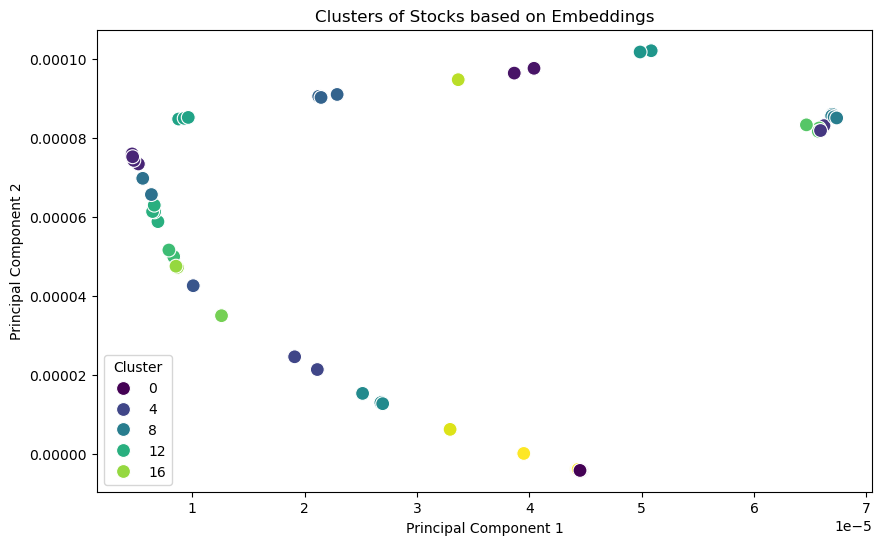

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Perform K-means clustering
n_clusters = 20  # You can choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings_array)

# Create a dataframe to store permno_id and their corresponding cluster

cluster_df = pd.DataFrame({"permno_id": permno_ids, "cluster": clusters})

# Print permno_id in each cluster
for cluster in range(n_clusters):
    cluster_members = cluster_df[cluster_df["cluster"] == cluster]["permno_id"].tolist()
    print(f"Cluster {cluster}: {cluster_members}")

# Plot the clusters using PCA for dimensionality reduction

pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings_array)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=clusters,
    palette="viridis",
    s=100,
)
plt.title("Clusters of Stocks based on Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

#### K-means & AgglomerativeClustering

- In this approach, you directly apply Agglomerative Clustering to the original embeddings.
- The metric='cosine' parameter tells the algorithm to use cosine distance (1 - cosine similarity) as the metric for clustering.
- The linkage='average' parameter specifies that the distance between clusters is the average distance between points in the clusters.

Cluster 0: ['20057', '20189']
Cluster 1: ['17334', '19285', '19286']
Cluster 2: ['18484', '18576']
Cluster 3: ['17685', '17700', '82686']
Cluster 4: ['18312', '76201', '79996', '82759']
Cluster 5: ['22623', '77668']
Cluster 6: ['18911', '18940', '79265']
Cluster 7: ['11896', '18592', '18724', '18726']
Cluster 8: ['12650', '18420', '18421', '18428']
Cluster 9: ['22206', '22265', '90441', '90442']
Cluster 10: ['88436']
Cluster 11: ['10909']
Cluster 12: ['19751']
Cluster 13: ['11552', '91063']
Cluster 14: ['17341']
Cluster 15: ['22976', '25778', '89757']
Cluster 16: ['18143']
Cluster 17: ['17307']
Cluster 18: ['10104', '10107', '10138', '10145', '10516', '10696', '11308', '11403', '11404', '11600', '11618', '11674', '11691', '11762', '11850', '11891', '11955', '12036', '12052', '12060', '12062', '12084', '12308', '12345', '12369', '12431', '12449', '12476', '12490', '12558', '12622', '12623', '12872', '13035', '13103', '13168', '13210', '13323', '13356', '13379', '13407', '13447', '13511'

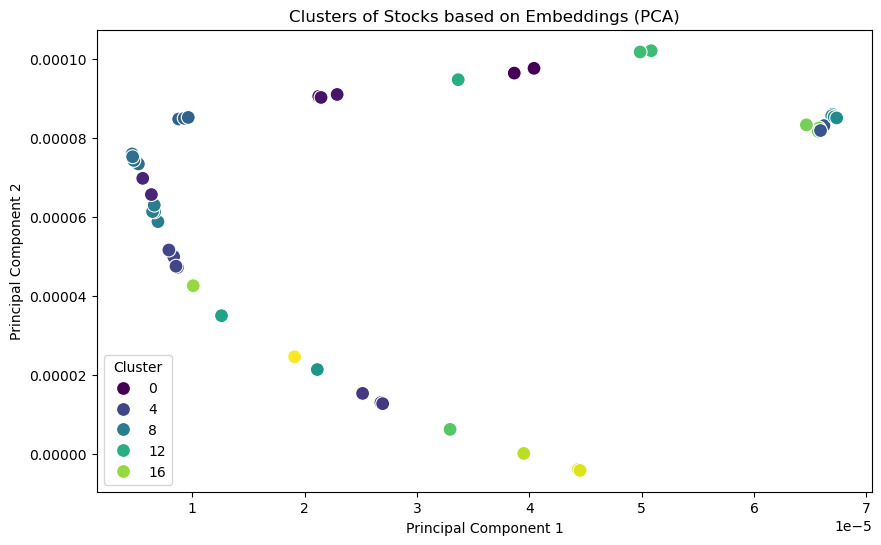

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings = np.array(list(stock_embeddings.values()))

# Perform Agglomerative Clustering with cosine affinity
n_clusters = 20
clustering = AgglomerativeClustering(n_clusters=n_clusters, metric="cosine", linkage="average")
labels = clustering.fit_predict(embeddings)

# Map permno_id to cluster labels
permno_id_to_cluster = {permno_id: label for permno_id, label in zip(stock_embeddings.keys(), labels)}

# Create a dictionary to hold lists of permno_ids for each cluster
clusters = {i: [] for i in range(n_clusters)}
for permno_id, cluster in permno_id_to_cluster.items():
    clusters[cluster].append(permno_id)

# Print the clustering results
for cluster, permno_ids in clusters.items():
    print(f"Cluster {cluster}: {permno_ids}")

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=labels,
    palette="viridis",
    s=100,
)
# for i, permno_id in enumerate(stock_embeddings.keys()):
#     plt.text(principal_components[i, 0], principal_components[i, 1], str(permno_id), fontsize=9)

plt.title("Clusters of Stocks based on Embeddings (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

#### K-means & Cosine Similarity
1. Cosine Similarity Transformation:  
    - Here, you first compute the cosine similarity matrix from the embeddings.
    - This matrix represents the cosine similarity between each pair of embeddings.
    - The similarity matrix is then used as the input to the KMeans clustering algorithm.  
2. KMeans Clustering:
    - KMeans is applied to the cosine similarity matrix, treating each similarity score as a feature.
    - This approach uses the similarity scores rather than the original embeddings to determine the clusters.

Cluster 0: ['61516', '61621', '61735', '62092', '62148', '62308', '62498', '63467', '64186', '64282', '64311', '64390', '64653', '64936', '64995', '65402', '65541', '65875', '65947', '66093', '66157', '66181', '66384', '66800', '67598', '69032', '69649', '69796', '70519', '70578', '71563', '72726', '73139', '75034', '75186', '75241', '75510', '75591', '75607', '75694', '75819', '75825', '75828', '75912', '76076', '76082', '76095', '76185', '76226', '76230', '76605', '76614', '76709', '76712', '76744', '76795', '76841', '77037', '77129', '77178', '77182', '77274', '77338', '77357', '77496', '77605', '77649', '77661', '77702', '77730', '78034', '78975', '78981', '78987', '79057', '79089', '79103', '79145', '79323', '79545', '79637', '79678', '79698', '79782', '79785', '79881', '79906', '80080', '80100', '80183', '80191', '80204', '80286', '80320', '80329', '80381', '80681', '80924', '81045', '81055', '81061', '81472', '81481', '81540', '81655', '81677', '81696', '81736', '81774', '82276'

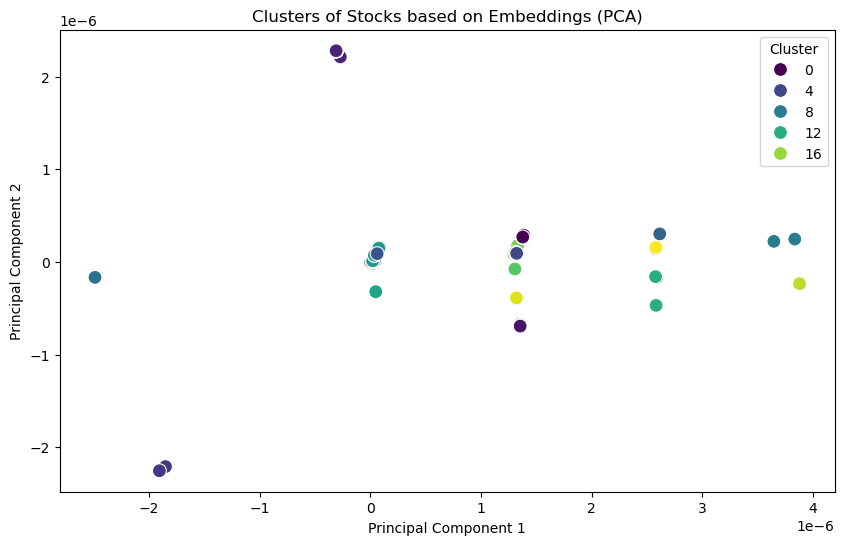

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)

# Apply KMeans on the transformed data
n_clusters = 20  # You can choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(cosine_sim_matrix)

# Map permno_id to cluster labels
permno_id_to_cluster = {permno_id: label for permno_id, label in zip(permno_ids, labels)}

# Create a dictionary to hold lists of permno_ids for each cluster
clusters = {i: [] for i in range(n_clusters)}
for permno_id, cluster in permno_id_to_cluster.items():
    clusters[cluster].append(permno_id)

# Print the clustering results
for cluster, permno_ids in clusters.items():
    print(f"Cluster {cluster}: {permno_ids}")

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(cosine_sim_matrix)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=labels,
    palette="viridis",
    s=100,
)
# for i, permno_id in enumerate(permno_ids):
#     plt.text(principal_components[i, 0], principal_components[i, 1], str(permno_id), fontsize=9)

plt.title("Clusters of Stocks based on Embeddings (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

#### Difference - AgglomerativeClustering and Cosine Similarity

Approach 1: Transforming Embeddings using Cosine Similarity and then Applying KMeans  
Approach 2: Agglomerative Clustering with Cosine Affinity  

1. Cosine Similarity Matrix vs. Original Embeddings:
    - Approach 1: Uses the cosine similarity matrix as the input for clustering. This means the clustering is based on the similarity scores between embeddings.  
    - Approach 2: Uses the original embeddings directly with cosine distance as the metric. The clustering is based on the pairwise cosine distances between embeddings.  
2. Clustering Algorithm:
    - Approach 1: Uses KMeans, which is a centroid-based algorithm. It aims to partition the data into clusters such that the sum of the squared distances from each point to its assigned centroid is minimized.  
    - Approach 2: Uses Agglomerative Clustering, which is a hierarchical clustering method. It builds a tree-like structure of clusters by merging pairs of clusters iteratively based on the specified linkage criterion and distance metric.  
3. Distance Metric Usage:  
    - Approach 1: Cosine similarity is precomputed and used as the input for clustering.  
    - Approach 2: Cosine distance is used directly within the clustering algorithm.|

#### Cosine Similarity Matrix

In [55]:
cosine_sim_matrix

array([[0.99999994, 0.99999994, 0.99999994, ..., 1.0000002 , 1.0000002 ,
        0.99999994],
       [0.99999994, 0.99999994, 0.99999994, ..., 1.0000002 , 1.0000002 ,
        0.99999994],
       [0.99999994, 0.99999994, 0.99999994, ..., 1.0000002 , 1.0000002 ,
        0.99999994],
       ...,
       [1.0000002 , 1.0000002 , 1.0000002 , ..., 0.99999994, 0.99999994,
        0.99999994],
       [1.0000002 , 1.0000002 , 1.0000002 , ..., 0.99999994, 0.99999994,
        0.99999994],
       [0.99999994, 0.99999994, 0.99999994, ..., 0.99999994, 0.99999994,
        0.99999994]], dtype=float32)

#### check negative value in cosine_sim_matrix

In [56]:
# Check for negative values in the cosine similarity matrix
negative_values = cosine_sim_matrix[cosine_sim_matrix < 0]

if len(negative_values) > 0:
    print(f"There are {len(negative_values)} negative values in the cosine similarity matrix.")
    print(negative_values)
else:
    print("There are no negative values in the cosine similarity matrix.")

There are no negative values in the cosine similarity matrix.


In [57]:
# Find the maximum value in the cosine similarity matrix
max_value = np.max(cosine_sim_matrix)
print(f"Max value: {max_value}")

# Find the minimum value in the cosine similarity matrix
min_value = np.min(cosine_sim_matrix)
print(f"Min value: {min_value}")

Max value: 1.000000238418579
Min value: 0.9999996423721313


Sample embeddings:
[[-0.10113669 -0.13117969  4.643764   -0.09728476 -0.13188404 -0.11414704
  -0.10199591 -0.09753642  5.2008724  -0.13804568 -0.10543156 -0.12181271
  -0.11092354 -0.10593085 -0.10379755 -0.12611543 -0.13012108 -0.10574751
  -0.10132074 -0.09109034 -0.1217372  -0.10508449 -0.12317963 -0.11023221
  -0.12776662 -0.10637771 -0.11569362 -0.1243245  -0.12921163 -0.12488127
  -0.13221206 -0.12708518 -0.34985635 -0.12901476 -0.12900788 -0.10293555
  -0.10689097 -0.12761888 -0.1141796  -0.13812514 -0.13206193 -0.10620784
  -0.13905913  0.5077686  -0.11439564 -0.10097685 -0.10466886 -0.14279886
  -0.11103318 -0.12519583 -0.12899232 -0.09925667 -0.12949999 -0.1302237
  -0.0958822  -0.11069038 -0.12490238 -0.13115653 -0.13030057 -0.10379748
  -0.099494   -0.12419097 -0.12821966 -3.0186055 ]
 [-0.10118653 -0.13112779  4.6437497  -0.09723199 -0.13183765 -0.11420897
  -0.10202868 -0.09758627  5.200917   -0.1380884  -0.10544573 -0.12179092
  -0.11095989 -0.10586552 -0.10382174 -0.12

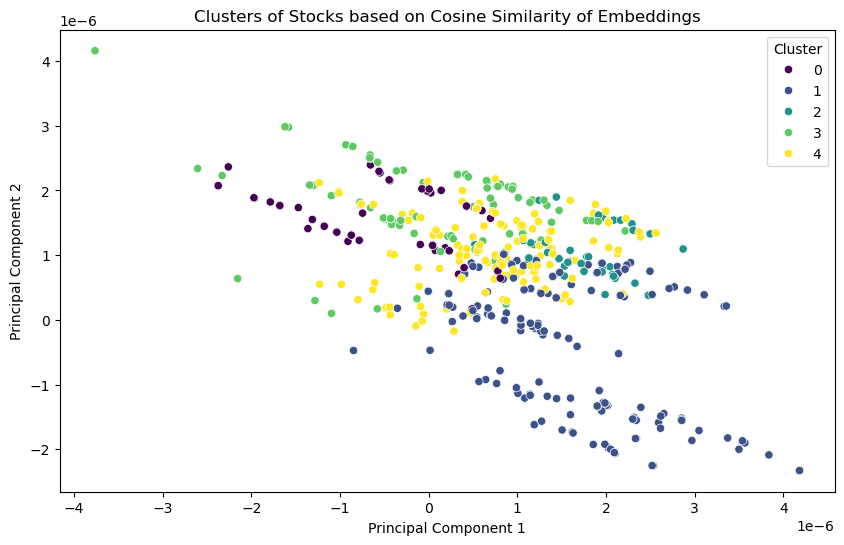

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Check the embeddings to ensure they have diverse values
print("Sample embeddings:")
print(embeddings_array[:5])

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)

# Check if there are any negative values in the cosine similarity matrix
print("Cosine Similarity Matrix Sample:")
print(cosine_sim_matrix[:5, :5])

# Ensure there are negative values
if np.any(cosine_sim_matrix < 0):
    print("Cosine similarity matrix contains negative values.")
else:
    print("Cosine similarity matrix does not contain negative values.")

# Perform K-means clustering
n_clusters = 5  # You can choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(cosine_sim_matrix)

# Create a dataframe to store permno_id and their corresponding cluster
import pandas as pd

cluster_df = pd.DataFrame({"permno_id": permno_ids, "cluster": clusters})

# Plot the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(cosine_sim_matrix)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=clusters,
    palette="viridis",
)
plt.title("Clusters of Stocks based on Cosine Similarity of Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

## Clustering Stocks Return

In [51]:
list(permno_id_to_cluster.items())[:10]

[('10104', 14),
 ('10107', 1),
 ('10138', 6),
 ('10145', 1),
 ('10516', 6),
 ('10696', 1),
 ('10909', 9),
 ('11308', 1),
 ('11403', 11),
 ('11404', 1)]

In [52]:
df_clustering = df

# Add cluster_id to the original data
df_clustering["cluster_id"] = df_clustering["permno_id"].map(permno_id_to_cluster)
df_clustering

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,equal_weighted_return,return_on_SP_index,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_id
9263,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.011232,0.008303,-0.013843,1.930296e+08,9.000972e+09,0.000000,0.000000,-0.0,-0.00064,14
9264,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.005103,0.006399,0.022897,1.975004e+08,9.422745e+09,0.021973,0.005694,0.0,-0.00064,14
9265,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.005272,0.004029,0.009803,1.994460e+08,9.609309e+09,0.002940,0.001681,0.0,-0.00064,14
9266,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.003880,0.007034,0.006001,2.006465e+08,9.725336e+09,0.015718,0.004005,0.0,-0.00064,14
9267,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.000584,0.001662,0.010467,2.027577e+08,9.931072e+09,0.006267,0.009789,0.0,-0.00064,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7658917,2023-12-22,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.007676,0.001660,-0.007731,8.028047e+08,2.027403e+11,-0.001753,0.016253,-0.0,-0.00064,11
7658918,2023-12-26,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.009674,0.004232,0.015988,8.157429e+08,2.093278e+11,0.006185,0.001010,0.0,-0.00064,11
7658919,2023-12-27,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.005276,0.001430,0.018647,8.310971e+08,2.172820e+11,0.003881,0.001242,0.0,-0.00064,11
7658920,2023-12-28,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.002042,0.000370,-0.032104,8.048392e+08,2.037692e+11,-0.002012,0.004141,-0.0,-0.00064,11


#### 1. Calculate the log returns of the clustering corresponding to each stock, calculated using the weighted average stock prices in the clustering

In [53]:
# First, group the data by cluster_id & date
grouped = (
    df_clustering.groupby(["cluster_id", "date"]).agg({"weighted_price": "sum", "market_cap": "sum"}).reset_index()
)

# Then, calculate the weighted average price
grouped["weighted_avg_price"] = grouped["weighted_price"] / grouped["market_cap"]

# Then, calculate the log return for each cluster_id
grouped["weighted_avg_price_shifted"] = grouped.groupby("cluster_id")["weighted_avg_price"].shift(1)
grouped["cluster_weighted_avg_log_return"] = (
    np.log(grouped["weighted_avg_price"] / grouped["weighted_avg_price_shifted"]).fillna(0)
).round(6)

grouped

,cluster_id,date,weighted_price,market_cap,weighted_avg_price,weighted_avg_price_shifted,cluster_weighted_avg_log_return
0,0,2018-01-02,2.724403e+11,2.031136e+09,134.131957,NaN,0.000000
1,0,2018-01-03,2.745722e+11,2.039307e+09,134.639972,134.131957,0.003780
2,0,2018-01-04,2.759041e+11,2.046690e+09,134.805061,134.639972,0.001225
3,0,2018-01-05,2.811508e+11,2.065263e+09,136.133184,134.805061,0.009804
4,0,2018-01-08,2.817589e+11,2.064198e+09,136.497987,136.133184,0.002676
...,...,...,...,...,...,...,...
25417,19,2018-12-17,5.266052e+09,5.449143e+07,96.640000,98.220000,-0.016217
25418,19,2018-12-18,5.092051e+09,5.358362e+07,95.030000,96.640000,-0.016800
25419,19,2018-12-19,5.174904e+09,5.401779e+07,95.800000,95.030000,0.008070
25420,19,2018-12-20,4.806810e+09,5.206119e+07,92.330000,95.800000,-0.036894


In [54]:
# Merge the clustering log returns back to the original dataframe
df_clustering = df_clustering.merge(
    grouped[["date", "cluster_id", "cluster_weighted_avg_log_return"]],
    on=["date", "cluster_id"],
    how="left",
)

df_clustering.head()

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,return_on_SP_index,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_id,cluster_weighted_avg_log_return
0,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.008303,-0.013843,1.930296e+08,9.000972e+09,0.000000,0.000000,-0.0,-0.00064,14,0.000000
1,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.006399,0.022897,1.975004e+08,9.422745e+09,0.021973,0.005694,0.0,-0.00064,14,0.021764
2,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.004029,0.009803,1.994460e+08,9.609309e+09,0.002940,0.001681,0.0,-0.00064,14,0.002430
3,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.007034,0.006001,2.006465e+08,9.725336e+09,0.015718,0.004005,0.0,-0.00064,14,0.016969
4,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.001662,0.010467,2.027577e+08,9.931072e+09,0.006267,0.009789,0.0,-0.00064,14,0.005760


In [55]:
df_clustering["cluster_weighted_avg_log_return"]

0         0.000000
1         0.021764
2         0.002430
3         0.016969
4         0.005760
            ...   
809878    0.002708
809879    0.008723
809880    0.009865
809881   -0.016219
809882   -0.008694
Name: cluster_weighted_avg_log_return, Length: 809883, dtype: float64

#### 2. Calculate the log returns of the clustering corresponding to each stock, calculated using the arithmetic average stock prices in the clustering

In [56]:
# First, group the data by cluster_id & date
grouped = (
    df_clustering.groupby(["cluster_id", "date"])
    .agg({"close_price": "mean"})
    .reset_index()
    .rename(columns={"close_price": "avg_price"})
)

# Then, calculate the log return for each cluster_id
grouped["avg_price_Shifted"] = grouped.groupby("cluster_id")["avg_price"].shift(1)
grouped["cluster_simple_avg_log_return"] = (
    np.log(grouped["avg_price"] / grouped["avg_price_Shifted"]).fillna(0)
).round(6)

grouped

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,cluster_id,date,avg_price,avg_price_Shifted,cluster_simple_avg_log_return
0,0,2018-01-02,108.603125,NaN,0.000000
1,0,2018-01-03,109.515313,108.603125,0.008364
2,0,2018-01-04,109.613282,109.515313,0.000894
3,0,2018-01-05,110.380938,109.613282,0.006979
4,0,2018-01-08,111.411250,110.380938,0.009291
...,...,...,...,...,...
25417,19,2018-12-17,96.640000,98.220000,-0.016217
25418,19,2018-12-18,95.030000,96.640000,-0.016800
25419,19,2018-12-19,95.800000,95.030000,0.008070
25420,19,2018-12-20,92.330000,95.800000,-0.036894


In [57]:
# Merge the clustering log returns back to the original dataframe
df_clustering = df_clustering.merge(
    grouped[["date", "cluster_id", "cluster_simple_avg_log_return"]],
    on=["date", "cluster_id"],
    how="left",
)

df_clustering.head()

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_id,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,-0.013843,1.930296e+08,9.000972e+09,0.000000,0.000000,-0.0,-0.00064,14,0.000000,0.000000
1,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.022897,1.975004e+08,9.422745e+09,0.021973,0.005694,0.0,-0.00064,14,0.021764,0.012446
2,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.009803,1.994460e+08,9.609309e+09,0.002940,0.001681,0.0,-0.00064,14,0.002430,0.005958
3,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.006001,2.006465e+08,9.725336e+09,0.015718,0.004005,0.0,-0.00064,14,0.016969,0.007333
4,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.010467,2.027577e+08,9.931072e+09,0.006267,0.009789,0.0,-0.00064,14,0.005760,0.001717


In [58]:
df_clustering["cluster_simple_avg_log_return"]

0         0.000000
1         0.012446
2         0.005958
3         0.007333
4         0.001717
            ...   
809878    0.012161
809879    0.004755
809880    0.001919
809881    0.000032
809882   -0.003015
Name: cluster_simple_avg_log_return, Length: 809883, dtype: float64

In [59]:
df_clustering.dtypes

date                               datetime64[ns]
permno_id                                  object
ncusip_id                                  object
cusip_id                                   object
ticker                                     object
share_code                                 object
share_code_type                            object
share_code_detail                          object
exchange_code                              object
company_name                               object
primary_exchange                           object
trading_status                             object
security_status                            object
naics                                      object
naics_sector                               object
naics_secondary                            object
ask_or_high_price                         float64
ask_price                                 float64
bid_or_low_price                          float64
bid_price                                 float64


In [60]:
df_clustering

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_id,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,-0.013843,1.930296e+08,9.000972e+09,0.000000,0.000000,-0.0,-0.00064,14,0.000000,0.000000
1,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.022897,1.975004e+08,9.422745e+09,0.021973,0.005694,0.0,-0.00064,14,0.021764,0.012446
2,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.009803,1.994460e+08,9.609309e+09,0.002940,0.001681,0.0,-0.00064,14,0.002430,0.005958
3,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.006001,2.006465e+08,9.725336e+09,0.015718,0.004005,0.0,-0.00064,14,0.016969,0.007333
4,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.010467,2.027577e+08,9.931072e+09,0.006267,0.009789,0.0,-0.00064,14,0.005760,0.001717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809878,2023-12-22,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,-0.007731,8.028047e+08,2.027403e+11,-0.001753,0.016253,-0.0,-0.00064,11,0.002708,0.012161
809879,2023-12-26,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.015988,8.157429e+08,2.093278e+11,0.006185,0.001010,0.0,-0.00064,11,0.008723,0.004755
809880,2023-12-27,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.018647,8.310971e+08,2.172820e+11,0.003881,0.001242,0.0,-0.00064,11,0.009865,0.001919
809881,2023-12-28,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,-0.032104,8.048392e+08,2.037692e+11,-0.002012,0.004141,-0.0,-0.00064,11,-0.016219,0.000032


## Step 3 dataset  
Including stock daily log_returns from most similar and most opposite cosine similarity 

In [61]:
df_clustering = df_clustering[["date", "permno_id", "log_return"]]

In [62]:
df_clustering.dtypes

date          datetime64[ns]
permno_id             object
log_return           float64
dtype: object

In [63]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


def find_similar_and_opposite_stocks(stock_embeddings, df_clustering, n=2):
    # Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
    embeddings_list = []
    permno_ids = []
    n = 2

    for permno_id, embedding in stock_embeddings.items():
        permno_ids.append(permno_id)
        embeddings_list.append(embedding)

    # Convert the list of embeddings to a numpy array
    embeddings_array = np.array(embeddings_list)

    # Transform embeddings using cosine similarity
    cosine_sim_matrix = cosine_similarity(embeddings_array)

    # Create a DataFrame for cosine similarity matrix for better handling
    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=permno_ids, columns=permno_ids)

    base = df_clustering.copy()[["date", "permno_id", "log_return"]]

    # Initialize new columns for most similar and most opposite stocks and their log returns
    for i in range(1, n + 1):
        df_clustering[f"most_similar_{i}"] = np.nan
        # df_clustering[f"most_similar_{i}_log_return"] = np.nan
        df_clustering[f"most_opposite_{i}"] = np.nan
        # df_clustering[f"most_opposite_{i}_log_return"] = np.nan

    # Ensure the new columns are of the same type as 'permno_id'
    df_clustering = df_clustering.astype({f"most_similar_{i}": "object" for i in range(1, n + 1)})
    df_clustering = df_clustering.astype({f"most_opposite_{i}": "object" for i in range(1, n + 1)})

    # Fill new columns with permno_id and log_return of most similar and most opposite stocks
    for permno_id in df_clustering["permno_id"].unique():
        similarities = cosine_sim_df.loc[permno_id]
        sorted_similarities = similarities.sort_values(ascending=False)
        most_similar = sorted_similarities.index[1 : n + 1]  # First n most similar stocks
        most_opposite = sorted_similarities.index[-n:]  # Last n most opposite stocks

        for i in range(n):
            similar_permno_id = most_similar[i]
            opposite_permno_id = most_opposite[i]

            # Set the most similar and most opposite permno_id
            df_clustering.loc[df_clustering["permno_id"] == permno_id, f"most_similar_{i+1}"] = similar_permno_id
            df_clustering.loc[df_clustering["permno_id"] == permno_id, f"most_opposite_{i+1}"] = opposite_permno_id

    # Merge the similar stock returns
    for i in range(1, n + 1):
        df_clustering = df_clustering.merge(
            base.rename(columns={"permno_id": f"most_similar_{i}", "log_return": f"most_similar_{i}_log_return"}),
            on=["date", f"most_similar_{i}"],
            how="left",
        )

    # Merge the opposite stock returns
    for i in range(1, n + 1):
        df_clustering = df_clustering.merge(
            base.rename(columns={"permno_id": f"most_opposite_{i}", "log_return": f"most_opposite_{i}_log_return"}),
            on=["date", f"most_opposite_{i}"],
            how="left",
        )

    # for feat in ["most_similar_1", "most_opposite_1", "most_similar_2", "most_opposite_2"]:
    #     df_clustering = df_clustering.merge(base.rename(columns = {"permno_id": f"{feat}", "log_return": f"{feat}_log_return"}), on = ["date", feat], how = "left")

    return df_clustering


# Example usage:
df_clustering = find_similar_and_opposite_stocks(stock_embeddings, df_clustering, n=3)
df_clustering

/tmp/ipykernel_151/2281485965.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering[f"most_similar_{i}"] = np.nan
/tmp/ipykernel_151/2281485965.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering[f"most_opposite_{i}"] = np.nan
/tmp/ipykernel_151/2281485965.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

,date,permno_id,log_return,most_similar_1,most_opposite_1,most_similar_2,most_opposite_2,most_similar_1_log_return,most_similar_2_log_return,most_opposite_1_log_return,most_opposite_2_log_return
0,2018-01-02,10104,-0.013843,20057,90071,22265,90199,NaN,NaN,0.014639,0.011707
1,2018-01-03,10104,0.022897,20057,90071,22265,90199,NaN,NaN,-0.000692,0.008409
2,2018-01-04,10104,0.009803,20057,90071,22265,90199,NaN,NaN,-0.011493,-0.003173
3,2018-01-05,10104,0.006001,20057,90071,22265,90199,NaN,NaN,0.006285,0.004982
4,2018-01-08,10104,0.010467,20057,90071,22265,90199,NaN,NaN,0.015199,0.012794
...,...,...,...,...,...,...,...,...,...,...,...
809878,2023-12-22,93436,-0.007731,91063,90071,20189,90199,NaN,-0.000298,-0.001799,0.004796
809879,2023-12-26,93436,0.015988,91063,90071,20189,90199,NaN,-0.006687,0.016070,0.007152
809880,2023-12-27,93436,0.018647,91063,90071,20189,90199,NaN,0.008278,0.008037,0.011061
809881,2023-12-28,93436,-0.032104,91063,90071,20189,90199,NaN,-0.004778,0.012418,0.001920


### Check

In [69]:
df_clustering[df_clustering["most_opposite_1"] == "90071"][["date", "permno_id", "most_opposite_1_log_return"]]

,date,permno_id,most_opposite_1_log_return
0,2018-01-02,10104,0.014639
1,2018-01-03,10104,-0.000692
2,2018-01-04,10104,-0.011493
3,2018-01-05,10104,0.006285
4,2018-01-08,10104,0.015199
...,...,...,...
809878,2023-12-22,93436,-0.001799
809879,2023-12-26,93436,0.016070
809880,2023-12-27,93436,0.008037
809881,2023-12-28,93436,0.012418


In [70]:
df_clustering[df_clustering["permno_id"] == "90071"][["date", "permno_id", "log_return"]]

,date,permno_id,log_return
736355,2018-01-02,90071,0.014639
736356,2018-01-03,90071,-0.000692
736357,2018-01-04,90071,-0.011493
736358,2018-01-05,90071,0.006285
736359,2018-01-08,90071,0.015199
...,...,...,...
737859,2023-12-22,90071,-0.001799
737860,2023-12-26,90071,0.016070
737861,2023-12-27,90071,0.008037
737862,2023-12-28,90071,0.012418


In [71]:
nan_counts = df_clustering.isna().sum()
print(nan_counts)

date                               0
permno_id                          0
log_return                         0
most_similar_1                     0
most_opposite_1                    0
most_similar_2                     0
most_opposite_2                    0
most_similar_1_log_return     510100
most_similar_2_log_return     537686
most_opposite_1_log_return      5155
most_opposite_2_log_return      8086
dtype: int64


In [72]:
any_nans = df_clustering.isna().any()
print(any_nans)

date                          False
permno_id                     False
log_return                    False
most_similar_1                False
most_opposite_1               False
most_similar_2                False
most_opposite_2               False
most_similar_1_log_return      True
most_similar_2_log_return      True
most_opposite_1_log_return     True
most_opposite_2_log_return     True
dtype: bool


In [73]:
any_nans_overall = df_clustering.isna().any().any()
print(f"Are there any NaN values in the DataFrame? {any_nans_overall}")

Are there any NaN values in the DataFrame? True


In [74]:
rows_with_nans = df_clustering[df_clustering.isna().any(axis=1)]
rows_with_nans

,date,permno_id,log_return,most_similar_1,most_opposite_1,most_similar_2,most_opposite_2,most_similar_1_log_return,most_similar_2_log_return,most_opposite_1_log_return,most_opposite_2_log_return
0,2018-01-02,10104,-0.013843,20057,90071,22265,90199,NaN,NaN,0.014639,0.011707
1,2018-01-03,10104,0.022897,20057,90071,22265,90199,NaN,NaN,-0.000692,0.008409
2,2018-01-04,10104,0.009803,20057,90071,22265,90199,NaN,NaN,-0.011493,-0.003173
3,2018-01-05,10104,0.006001,20057,90071,22265,90199,NaN,NaN,0.006285,0.004982
4,2018-01-08,10104,0.010467,20057,90071,22265,90199,NaN,NaN,0.015199,0.012794
...,...,...,...,...,...,...,...,...,...,...,...
809878,2023-12-22,93436,-0.007731,91063,90071,20189,90199,NaN,-0.000298,-0.001799,0.004796
809879,2023-12-26,93436,0.015988,91063,90071,20189,90199,NaN,-0.006687,0.016070,0.007152
809880,2023-12-27,93436,0.018647,91063,90071,20189,90199,NaN,0.008278,0.008037,0.011061
809881,2023-12-28,93436,-0.032104,91063,90071,20189,90199,NaN,-0.004778,0.012418,0.001920


### replace NaN with 0 and add new columns to indicate them
1. If there was values in the columns "most_similar_log_return" and "most_opposite_log_return", then fill 1.
2. If there was NaN in the columns "most_similar_log_return" and "most_opposite_log_return", then fill 0.
3. replace the NaN with 0 for the columns "most_similar_log_return" and "most_opposite_log_return"

In [75]:
df_clustering

,date,permno_id,log_return,most_similar_1,most_opposite_1,most_similar_2,most_opposite_2,most_similar_1_log_return,most_similar_2_log_return,most_opposite_1_log_return,most_opposite_2_log_return
0,2018-01-02,10104,-0.013843,20057,90071,22265,90199,NaN,NaN,0.014639,0.011707
1,2018-01-03,10104,0.022897,20057,90071,22265,90199,NaN,NaN,-0.000692,0.008409
2,2018-01-04,10104,0.009803,20057,90071,22265,90199,NaN,NaN,-0.011493,-0.003173
3,2018-01-05,10104,0.006001,20057,90071,22265,90199,NaN,NaN,0.006285,0.004982
4,2018-01-08,10104,0.010467,20057,90071,22265,90199,NaN,NaN,0.015199,0.012794
...,...,...,...,...,...,...,...,...,...,...,...
809878,2023-12-22,93436,-0.007731,91063,90071,20189,90199,NaN,-0.000298,-0.001799,0.004796
809879,2023-12-26,93436,0.015988,91063,90071,20189,90199,NaN,-0.006687,0.016070,0.007152
809880,2023-12-27,93436,0.018647,91063,90071,20189,90199,NaN,0.008278,0.008037,0.011061
809881,2023-12-28,93436,-0.032104,91063,90071,20189,90199,NaN,-0.004778,0.012418,0.001920


In [76]:
# Identify the columns that are related to most similar and most opposite log returns
similar_opposite_cols = [
    col for col in df_clustering.columns if "_log_return" in col and ("most_similar" in col or "most_opposite" in col)
]

# Add new columns to indicate if the value was NaN
for col in similar_opposite_cols:
    df_clustering[f"{col}_was_nan"] = np.where(df_clustering[col].isna(), 0, 1)

# Replace NaN values with 0 in the identified columns
df_clustering[similar_opposite_cols] = df_clustering[similar_opposite_cols].fillna(0)

# Example check
df_clustering

,date,permno_id,log_return,most_similar_1,most_opposite_1,most_similar_2,most_opposite_2,most_similar_1_log_return,most_similar_2_log_return,most_opposite_1_log_return,most_opposite_2_log_return,most_similar_1_log_return_was_nan,most_similar_2_log_return_was_nan,most_opposite_1_log_return_was_nan,most_opposite_2_log_return_was_nan
0,2018-01-02,10104,-0.013843,20057,90071,22265,90199,0.0,0.000000,0.014639,0.011707,0,0,1,1
1,2018-01-03,10104,0.022897,20057,90071,22265,90199,0.0,0.000000,-0.000692,0.008409,0,0,1,1
2,2018-01-04,10104,0.009803,20057,90071,22265,90199,0.0,0.000000,-0.011493,-0.003173,0,0,1,1
3,2018-01-05,10104,0.006001,20057,90071,22265,90199,0.0,0.000000,0.006285,0.004982,0,0,1,1
4,2018-01-08,10104,0.010467,20057,90071,22265,90199,0.0,0.000000,0.015199,0.012794,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809878,2023-12-22,93436,-0.007731,91063,90071,20189,90199,0.0,-0.000298,-0.001799,0.004796,0,1,1,1
809879,2023-12-26,93436,0.015988,91063,90071,20189,90199,0.0,-0.006687,0.016070,0.007152,0,1,1,1
809880,2023-12-27,93436,0.018647,91063,90071,20189,90199,0.0,0.008278,0.008037,0.011061,0,1,1,1
809881,2023-12-28,93436,-0.032104,91063,90071,20189,90199,0.0,-0.004778,0.012418,0.001920,0,1,1,1


In [77]:
df_clustering.columns

Index(['date', 'permno_id', 'log_return', 'most_similar_1', 'most_opposite_1',
       'most_similar_2', 'most_opposite_2', 'most_similar_1_log_return',
       'most_similar_2_log_return', 'most_opposite_1_log_return',
       'most_opposite_2_log_return', 'most_similar_1_log_return_was_nan',
       'most_similar_2_log_return_was_nan',
       'most_opposite_1_log_return_was_nan',
       'most_opposite_2_log_return_was_nan'],
      dtype='object')

In [78]:
nan_counts = df_clustering.isna().sum()
print(nan_counts)

date                                  0
permno_id                             0
log_return                            0
most_similar_1                        0
most_opposite_1                       0
most_similar_2                        0
most_opposite_2                       0
most_similar_1_log_return             0
most_similar_2_log_return             0
most_opposite_1_log_return            0
most_opposite_2_log_return            0
most_similar_1_log_return_was_nan     0
most_similar_2_log_return_was_nan     0
most_opposite_1_log_return_was_nan    0
most_opposite_2_log_return_was_nan    0
dtype: int64


## Save the cleaned df as csv & parquet


In [51]:
df_clustering.to_csv(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.csv",
    index=False,
)
df_clustering.to_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.parquet")

In [52]:
reload = pd.read_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.parquet")
assert df_clustering.equals(reload)

reload.head()

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_id,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,-0.013843,1.930296e+08,9.000972e+09,0.000000,0.000000,-0.0,-0.00064,16,0.000000,0.000000
1,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.022897,1.975004e+08,9.422745e+09,0.021973,0.005694,0.0,-0.00064,16,0.010933,0.009348
2,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.009803,1.994460e+08,9.609309e+09,0.002940,0.001681,0.0,-0.00064,16,-0.001095,0.000711
3,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.006001,2.006465e+08,9.725336e+09,0.015718,0.004005,0.0,-0.00064,16,0.000353,0.002520
4,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.010467,2.027577e+08,9.931072e+09,0.006267,0.009789,0.0,-0.00064,16,0.001616,0.002617


## Upload the parquet to s3


In [53]:
s3.upload_file(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.parquet",
    bucket,
    "CRSP/crsp_2018-2023_clean_clustering.parquet",
)

In [54]:
reload_path = s3_download("CRSP/crsp_2018-2023_clean_clustering.parquet")

In [55]:
reload = pd.read_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.parquet")
assert df_clustering.equals(reload)

reload.head()

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_id,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,-0.013843,1.930296e+08,9.000972e+09,0.000000,0.000000,-0.0,-0.00064,16,0.000000,0.000000
1,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.022897,1.975004e+08,9.422745e+09,0.021973,0.005694,0.0,-0.00064,16,0.010933,0.009348
2,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.009803,1.994460e+08,9.609309e+09,0.002940,0.001681,0.0,-0.00064,16,-0.001095,0.000711
3,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.006001,2.006465e+08,9.725336e+09,0.015718,0.004005,0.0,-0.00064,16,0.000353,0.002520
4,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.010467,2.027577e+08,9.931072e+09,0.006267,0.009789,0.0,-0.00064,16,0.001616,0.002617
